In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from pycaret.regression import setup, compare_models
from sklearn.model_selection import cross_val_score, KFold
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
def quartile_limits(data):
    q1, q2, q3 = data.quantile([0.25,0.5,0.75])
    return q1, q2, q3, q3 - q1

def feature_stats(feature):
    q1, q2, q3, iqr = quartile_limits(train[feature])
    mean = np.nanmean(train[feature])
    med = np.nanmedian(train[feature])
    outlier_lim_neg = q1-(3*iqr)
    outlier_lim_pos = q3+(3*iqr)
    bad_pos = len(train[feature][train[feature] > outlier_lim_pos])
    bad_neg = len(train[feature][train[feature] < outlier_lim_neg])
    return mean, med, outlier_lim_neg, outlier_lim_pos, bad_neg, bad_pos 

def feature_plot(xax,yax):
    ymin = train[yax].min()
    ymax = train[yax].max()
    mean, med, outlier_lim_neg, outlier_lim_pos, bad_neg, bad_pos = feature_stats(xax)
    plt.figure(figsize = (20,5))
    sns.regplot(x = train[xax], y = train[yax], scatter_kws={'alpha': 0.4}, line_kws={'color': 'red','linewidth':0.8})
    if outlier_lim_neg > train[feature].min():
        plt.plot([outlier_lim_neg,outlier_lim_neg], [ymin,ymax], linestyle = 'dashed', color = 'red')
    plt.plot([mean,mean], [ymin,ymax], linestyle = 'dashed', color = 'orange')
    plt.plot([med,med], [ymin,ymax], linestyle = 'dashed', color = 'darkgreen')
    if outlier_lim_pos < train[feature].max():
        plt.plot([outlier_lim_pos,outlier_lim_pos], [ymin,ymax], linestyle = 'dashed', color = 'red')

def missing_columns(df):
    data = df.copy()
    columns = data.columns
    results = pd.DataFrame([],columns = ['Feature','Missing','Percent'])
    for column in columns:
        count = data[column].isnull().sum()
        if count != 0:
            percent = round(100*count/len(data[column]),2)
            results.loc[len(results)] = [column, count, percent] 
    return results

def check_importance(column1,column2, threshold):
    import seaborn as sns
    import matplotlib.pyplot as plt
    data = train.copy()
    data = data[[column2,column1]]
    features = len(data[column2].unique())
    p = sns.countplot(data = data, x = column2)
    if features > 10:
        p.set(xticklabels = [])
    if data.dtypes[column2] != 'O':
        corr_all = round(data.corr(),3)
        temp = corr_all[column1]
        if temp[0] >= threshold:
            print('The feature correlation (' + str(temp[0]) + ') is above the threshold.')
        else:
            print('The feature correlates below the threshold.')
    else:
        data = pd.get_dummies(data, columns = [column2])
        corr_each = round(data.corr(),3)
        temp = corr_each[column1]
        temp = temp[1:]
        if len(temp[temp >= threshold]) > 0:
            print('Dummied features above threshold:')
            print(temp[temp.abs() >= threshold].sort_values(ascending = False))
        else:
            print('All features below threshold.')

def compile_features(threshold):
    dummy_list = ['SalePrice']
    feature_list = []
    data = train.copy()
    data.drop('SalePrice', axis=1, inplace=True)
    features = data.columns
    data = train.copy()
    for feature in features:
        temp = data[['SalePrice',feature]]
        if temp.dtypes[feature] == 'O':
            temp = pd.get_dummies(temp, columns = [feature])
        correlations = round(temp.corr(),3)
        results = correlations['SalePrice']
        include = results[results.abs() >= threshold].sort_values(ascending = False)
        include = include[1:]
        if len(include) > 0:
            feature_list.append(feature)
            if data.dtypes[feature] == 'O':
                for i in include.index:
                    dummy_list.append(i)
    return feature_list, dummy_list

def log_diff(actual, predicted):
    actual = np.log(actual)
    predicted = np.log(predicted.astype(int))
    return 1-np.sqrt(np.sum(np.square(actual-predicted))/len(actual))

def reg_results(Regressor,dfX,dfy, scorer, param_dict):
    # Inputs are:
    # 1 The regressor you wish to tune.
    # 2 A dataframe containing the features to be analysed.
    # 3 The target labels.
    # 4 The scoring function you wish to use. Make sure it works with a higher score is best.
    # 5 A dict of parameters to be used with GridSearchCV.
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    X = dfX.copy()
    y = dfy.copy()
    reg = Regressor()
    scores = make_scorer(log_diff, greater_is_better = True)
    grid_clf = GridSearchCV(reg, param_grid = param_dict, scoring = scores)
    Grid = grid_clf.fit(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    reg.fit(X_train, y_train)
    predictions = pd.Series(reg.predict(X_test))
    scr = round(scorer(y_test, predictions),4)
    var = np.std(predictions)
    xax = np.arange(1,len(y_test)+1)
    yax_abs = y_test-predictions.values
    yax_pct = 100*yax_abs/y_test
    plt.figure(figsize = [20,5])
    plt.subplot(1,2,1)
    plt.scatter(xax,predictions.values,s=4)
    plt.xlim([xax[0], xax[-1]])
    plt.ylim([11, 13])
    plt.xlabel('True', fontsize=18)
    plt.ylabel('Predicted value', fontsize=18)
    plt.title(Regressor.__name__, fontsize=18)
    plt.subplot(1,2,2)
    plt.scatter(xax,yax_pct,s=4)
    plt.plot([np.min(xax),np.max(xax)],[0,0],c='r')
    plt.xlim([xax[0], xax[-1]])
    plt.xlabel('True', fontsize=18)
    plt.ylabel('% difference from True', fontsize=18)
    plt.title(Regressor.__name__, fontsize=18)
    return Grid.best_score_, Grid.best_params, scr

In [3]:
# Load files.
train = pd.read_csv('train.csv')
predict = pd.read_csv('test.csv')
# Set the indices to the Id number.
train.set_index('Id', inplace=True)
predict.set_index('Id', inplace=True)

In [4]:
# Check that SalePrice is the only column unique to either dataframe.
train_col = train.columns
predict_col = predict.columns
print(train_col.difference(predict_col))
print(predict_col.difference(train_col))

Index(['SalePrice'], dtype='object')
Index([], dtype='object')


# Data cleaning

# - Training set

In [5]:
# Look at which features are missing values. To resolve this will depend on the feature.
# If the feature is numerical, it may be possible to substitute in a value from the rest of the data.
# Many of the categorical features refer to the presence of a component of the house. If the component was not 
# present on the property, the entry was left empty. Once loaded into python, the empty entries were filled with Nan.
# As the lack of the component is useful for analysis, a new label called 'None' will be created.
# For the rest of the categorical features, the most common value/label will be used.
before_train = len(train)
missing_columns(train)

,Feature,Missing,Percent
0,LotFrontage,259,17.74
1,Alley,1369,93.77
2,MasVnrType,8,0.55
3,MasVnrArea,8,0.55
4,BsmtQual,37,2.53
5,BsmtCond,37,2.53
6,BsmtExposure,38,2.60
7,BsmtFinType1,37,2.53
8,BsmtFinType2,38,2.60
9,Electrical,1,0.07


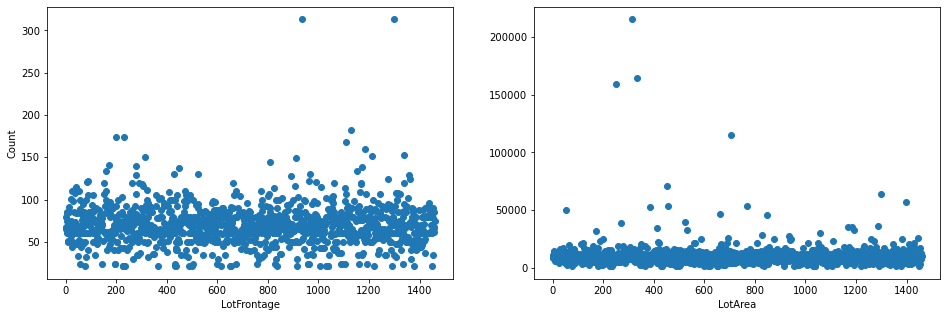

In [6]:
# LotFrontage has many missing values. Assuming a roughly rectangular plot, the missing values might be substituted
# by typical frontage values plot plots with similar areas. However, apart from a few significantly large values,
# there is little range in the LotFrontage. Due to this, it is better to take a typical value of the whole dataset.
# Due to the presence of the extreme values, a median is a better substitute than the mean.
fig = plt.figure(figsize=(16,5));
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
xax = np.arange(1,len(train)+1)
yax1 = train['LotFrontage']
yax2 = train['LotArea']
ax1.scatter(xax,yax1)
ax1.set_xlabel('LotFrontage');
ax1.set_ylabel('Count');
ax2.scatter(xax,yax2)
ax2.set_xlabel('LotArea');
ax1.set_ylabel('Count');

In [7]:
# The MasVnrArea missing values correspond with the missing values from MasVnrType.
# As these are houses with no masonry veneer, the area will be zero.

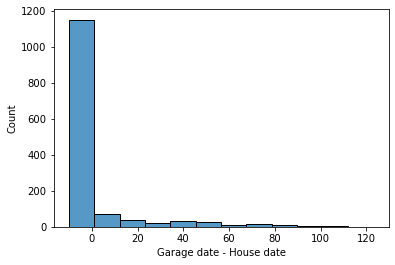

In [8]:
# Looking at the difference between when the house was built and when the garage was built, it is clear that most
# garages were built around the same time as the house. It would be reasonable to fill in any missing values with
# the build year of the house.
sns.histplot(train['GarageYrBlt'] - train['YearBuilt']);
plt.xlabel('Garage date - House date');

In [9]:
train['LotFrontage'] = train['LotFrontage'].fillna(np.round(train.loc[:,'LotFrontage'].median(), 0))
train['MasVnrArea'] = train['MasVnrArea'].fillna(0)
mask = train['GarageYrBlt'].isnull() == True
train.loc[mask, 'GarageYrBlt'] = train.loc[mask, 'YearBuilt']

In [10]:
# Apply the 'None' label to entries for which the feature does not apply.
train['Alley'] = train['Alley'].fillna('None')
train['Electrical'] = train['Electrical'].fillna('None')
train['MiscFeature'] = train['MiscFeature'].fillna('None')
train['GarageType'] = train['GarageType'].fillna('None')
train['GarageFinish'] = train['GarageFinish'].fillna('None')
train['GarageQual'] = train['GarageQual'].fillna('None')
train['GarageCond'] = train['GarageCond'].fillna('None')
train['MasVnrType'] = train['MasVnrType'].fillna('None')
train['BsmtQual'] = train['BsmtQual'].fillna('None')
train['BsmtCond'] = train['BsmtCond'].fillna('None')
train['BsmtExposure'] = train['BsmtExposure'].fillna('None')
train['BsmtFinType1'] = train['BsmtFinType1'].fillna('None')
train['BsmtFinType2'] = train['BsmtFinType2'].fillna('None')
train['FireplaceQu'] = train['FireplaceQu'].fillna('None')
train['PoolQC'] = train['PoolQC'].fillna('None')
train['Fence'] = train['Fence'].fillna('None')

In [11]:
# Check that all the missing values have been taken care of.
missing_columns(train)

,Feature,Missing,Percent


# - Prediction set

In [12]:
# Most features in the predictions set are only missing 1-2 entries. Therefore those rows can be removed.
# For consistency, the same steps used to clean the training set will be used on the prediction set.
missing_columns(predict)

,Feature,Missing,Percent
0,MSZoning,4,0.27
1,LotFrontage,227,15.56
2,Alley,1352,92.67
3,Utilities,2,0.14
4,Exterior1st,1,0.07
5,Exterior2nd,1,0.07
6,MasVnrType,16,1.10
7,MasVnrArea,15,1.03
8,BsmtQual,44,3.02
9,BsmtCond,45,3.08


In [13]:
predict['LotFrontage'] = predict['LotFrontage'].fillna(np.round(predict.loc[:,'LotFrontage'].median(), 0))
predict['MasVnrArea'] = predict['MasVnrArea'].fillna(0)
mask = predict['GarageYrBlt'].isnull() == True
predict.loc[mask, 'GarageYrBlt'] = predict.loc[mask, 'YearBuilt']

In [14]:
predict['Alley'] = predict['Alley'].fillna('None')
predict['MiscFeature'] = predict['MiscFeature'].fillna('None')
predict['GarageType'] = predict['GarageType'].fillna('None')
predict['GarageFinish'] = predict['GarageFinish'].fillna('None')
predict['GarageQual'] = predict['GarageQual'].fillna('None')
predict['GarageCond'] = predict['GarageCond'].fillna('None')
predict['MasVnrType'] = predict['MasVnrType'].fillna('None')
predict['BsmtQual'] = predict['BsmtQual'].fillna('None')
predict['BsmtCond'] = predict['BsmtCond'].fillna('None')
predict['BsmtExposure'] = predict['BsmtExposure'].fillna('None')
predict['BsmtFinType1'] = predict['BsmtFinType1'].fillna('None')
predict['BsmtFinType2'] = predict['BsmtFinType2'].fillna('None')
predict['FireplaceQu'] = predict['FireplaceQu'].fillna('None')
predict['PoolQC'] = predict['PoolQC'].fillna('None')
predict['Fence'] = predict['Fence'].fillna('None')

In [15]:
# Replace the missing entries with the most common value/label.
predict['MSZoning'] = predict['MSZoning'].fillna(predict['MSZoning'].value_counts()[0])
predict['Utilities'] = predict['Utilities'].fillna(predict['Utilities'].value_counts()[0])
predict['Exterior1st'] = predict['Exterior1st'].fillna(predict['Exterior1st'].value_counts()[0])
predict['Exterior2nd'] = predict['Exterior2nd'].fillna(predict['Exterior2nd'].value_counts()[0])
predict['BsmtFinSF1'] = predict['BsmtFinSF1'].fillna(predict['BsmtFinSF1'].value_counts()[0])
predict['BsmtFinSF2'] = predict['BsmtFinSF2'].fillna(predict['BsmtFinSF2'].value_counts()[0])
predict['BsmtUnfSF'] = predict['BsmtUnfSF'].fillna(predict['BsmtUnfSF'].value_counts()[0])
predict['TotalBsmtSF'] = predict['TotalBsmtSF'].fillna(predict['TotalBsmtSF'].value_counts()[0])
predict['BsmtFullBath'] = predict['BsmtFullBath'].fillna(predict['BsmtFullBath'].value_counts()[0])
predict['BsmtHalfBath'] = predict['BsmtHalfBath'].fillna(predict['BsmtHalfBath'].value_counts()[0])
predict['KitchenQual'] = predict['KitchenQual'].fillna(predict['KitchenQual'].value_counts()[0])
predict['Functional'] = predict['Functional'].fillna(predict['Functional'].value_counts()[0])
predict['GarageCars'] = predict['GarageCars'].fillna(predict['GarageCars'].value_counts()[0])
predict['GarageArea'] = predict['GarageArea'].fillna(predict['GarageArea'].value_counts()[0])
predict['SaleType'] = predict['SaleType'].fillna(predict['SaleType'].value_counts()[0])

In [16]:
# Check that all the missing values have been taken care of.
missing_columns(predict)

,Feature,Missing,Percent


# Feature creation.

In [17]:
train['HouseAge'] = train['YrSold'] - train['YearBuilt']
train['GarageAge'] = train['YrSold'] - train['GarageYrBlt']
train['RemodelAge'] = train['YearRemodAdd'] - train['YearBuilt']

predict['HouseAge'] = predict['YrSold'] - predict['YearBuilt']
predict['GarageAge'] = predict['YrSold'] - predict['GarageYrBlt']
predict['RemodelAge'] = predict['YearRemodAdd'] - predict['YearBuilt']

# Feature analysis

# - Target

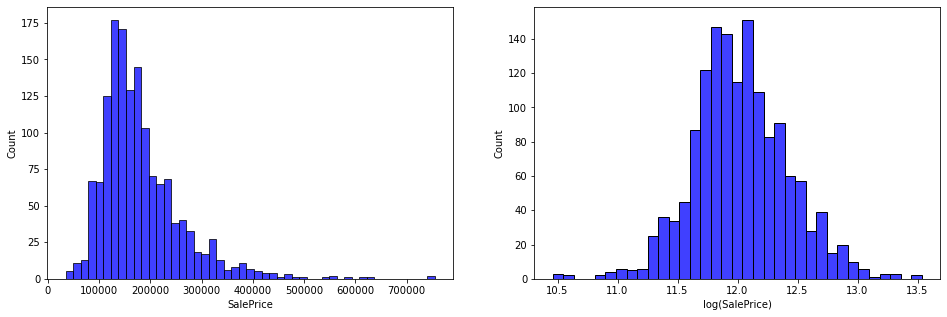

In [18]:
# For the best results, the distribution of the target needs to be Gaussian (symmetric and bell shaped).
# Looking at the distribution (left plot) it is clear that the target is skewed towards lower values.
# However the log of the target (right plot) produces a distribution much closer to what is desired.
fig = plt.figure(figsize=(16,5));
ax1 = fig.add_subplot(121);
ax2 = fig.add_subplot(122);
sns.histplot(train['SalePrice'],color = 'blue', ax = ax1)
sns.histplot(np.log(train['SalePrice']),color = 'blue',ax = ax2)
ax2.set_xlabel('log(SalePrice)');
train['LogSalePrice'] = np.log(train['SalePrice'])
train.drop('SalePrice', axis=1, inplace=True)

# - Feature correlation

In [19]:
correlations = train.corr()
correlations = correlations['LogSalePrice']
correlations = correlations.sort_values(key=abs, ascending = False)
correlations = correlations[1:]
correlations

OverallQual      0.817184
GrLivArea        0.700927
GarageCars       0.680625
GarageArea       0.650888
TotalBsmtSF      0.612134
1stFlrSF         0.596981
FullBath         0.594771
HouseAge        -0.587290
YearBuilt        0.586570
GarageAge       -0.569568
GarageYrBlt      0.568696
YearRemodAdd     0.565608
TotRmsAbvGrd     0.534422
Fireplaces       0.489449
MasVnrArea       0.426775
BsmtFinSF1       0.372023
LotFrontage      0.335292
WoodDeckSF       0.334135
OpenPorchSF      0.321053
2ndFlrSF         0.319300
HalfBath         0.313982
LotArea          0.257320
RemodelAge      -0.246724
BsmtFullBath     0.236224
BsmtUnfSF        0.221985
BedroomAbvGr     0.209044
EnclosedPorch   -0.149050
KitchenAbvGr    -0.147548
ScreenPorch      0.121208
MSSubClass      -0.073959
PoolArea         0.069798
MoSold           0.057329
3SsnPorch        0.054900
LowQualFinSF    -0.037963
YrSold          -0.037263
OverallCond     -0.036868
MiscVal         -0.020021
BsmtHalfBath    -0.005149
BsmtFinSF2  

In [20]:
# Produce lists of the numerical and categorical features.
# A subset of the numerical features that excludes features measured in years will be used to identify outliers.
all_cols = list(train.columns)
all_cols.remove('LogSalePrice')
numerical = list(correlations.index)
categorical = [x for x in all_cols if x not in numerical]
num_continuous = ['GrLivArea','GarageArea','TotalBsmtSF','1stFlrSF','HouseAge','GarageAge','MasVnrArea','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','LotArea','RemodelAge','BsmtUnfSF','EnclosedPorch','ScreenPorch','3SsnPorch','LowQualFinSF','MiscVal','BsmtFinSF2']

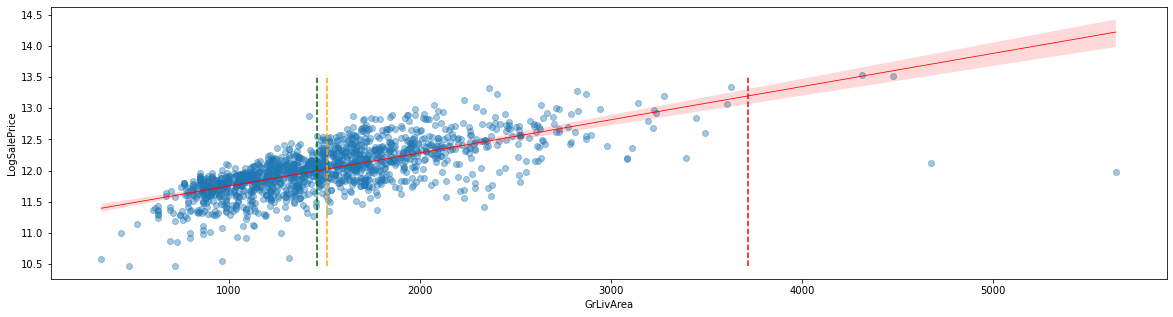

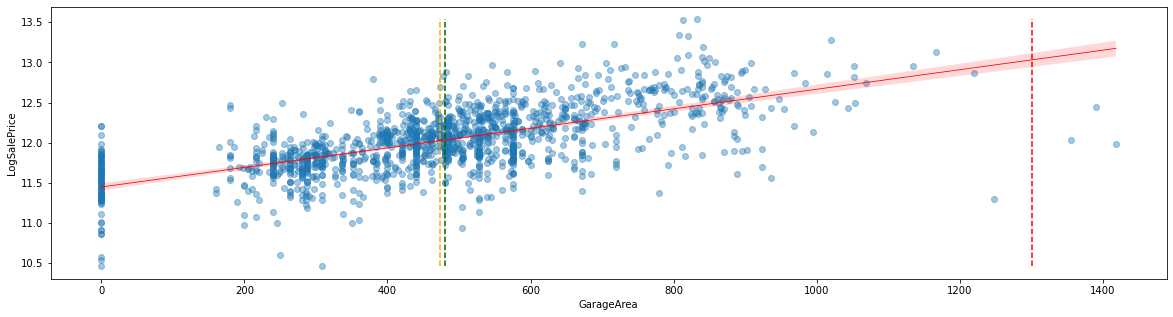

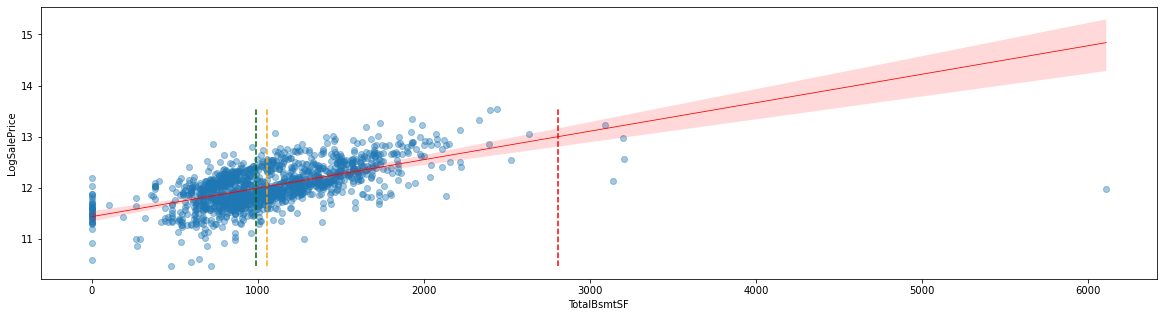

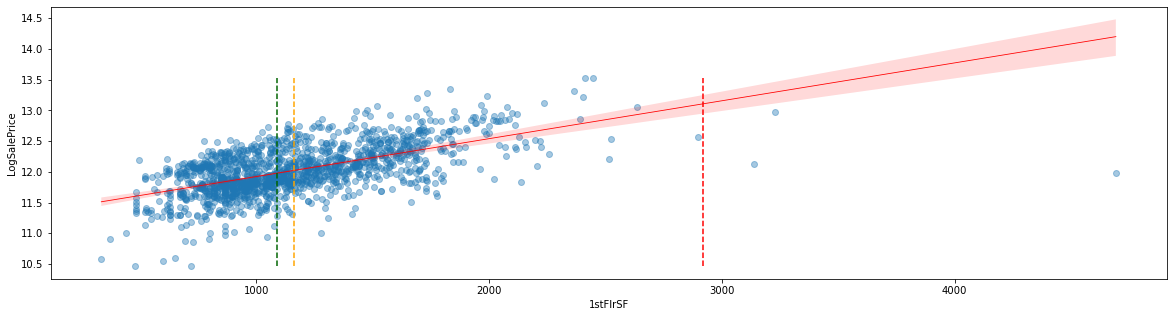

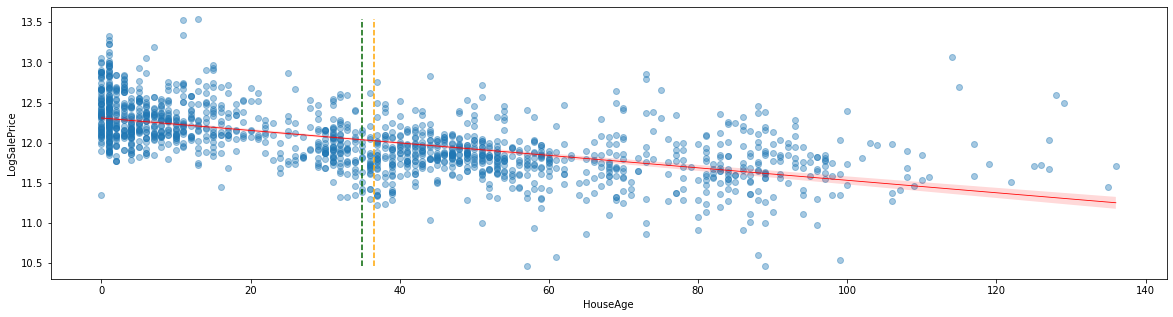

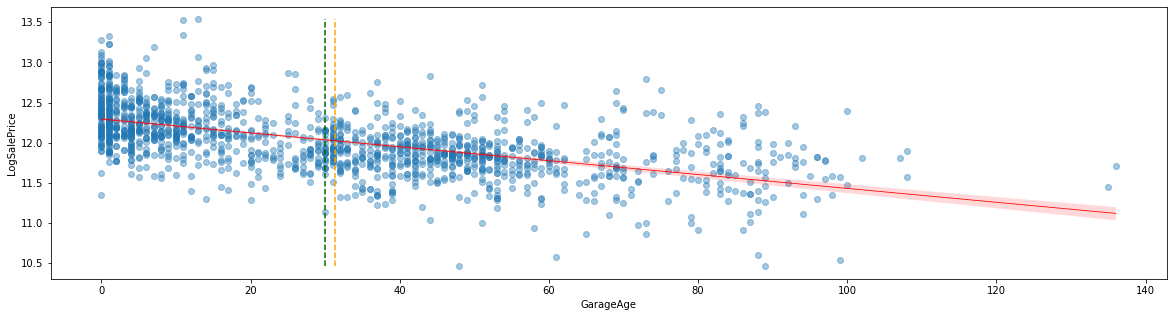

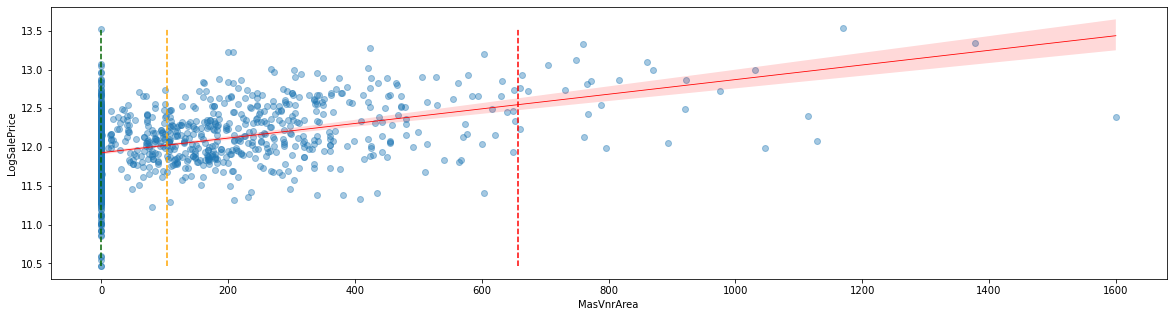

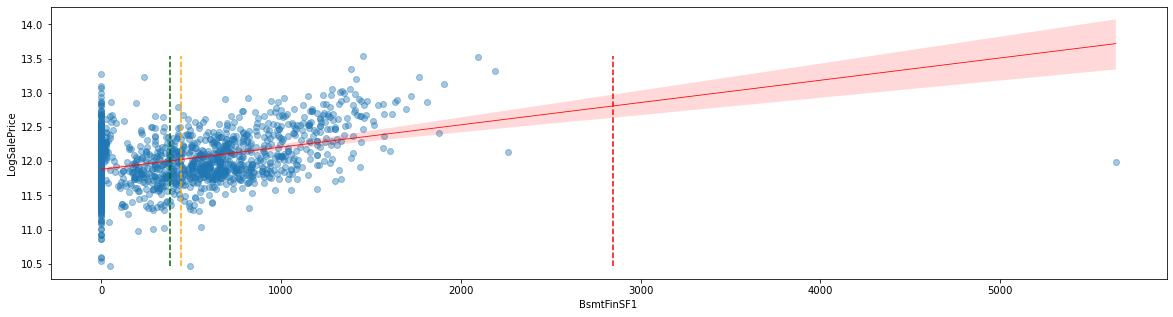

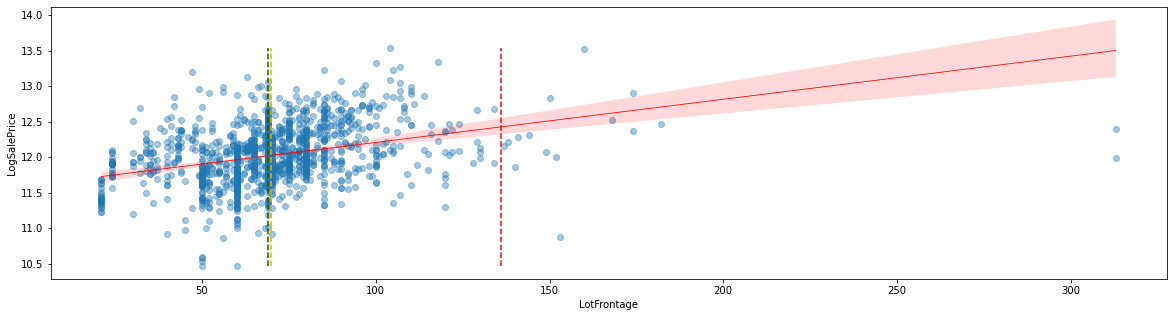

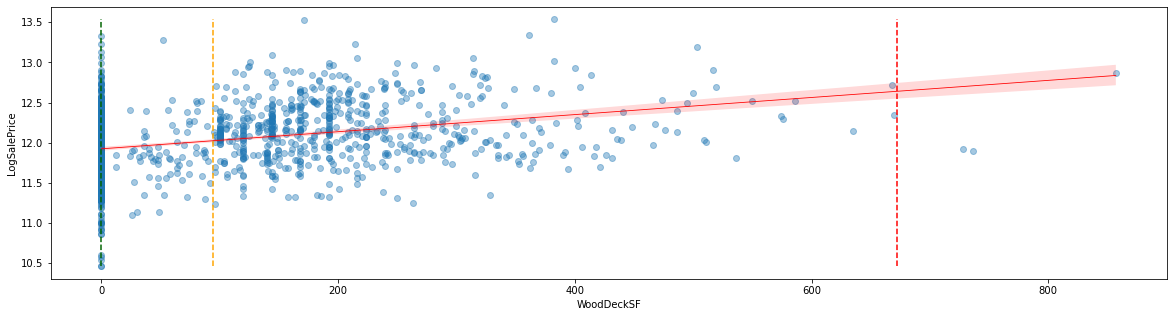

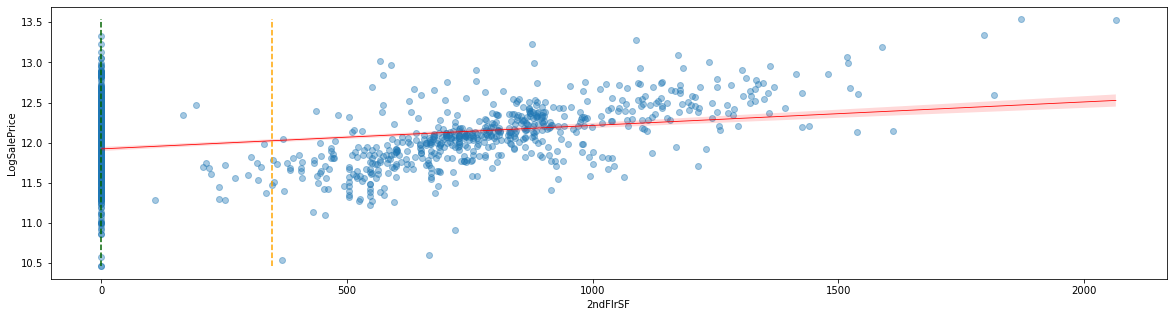

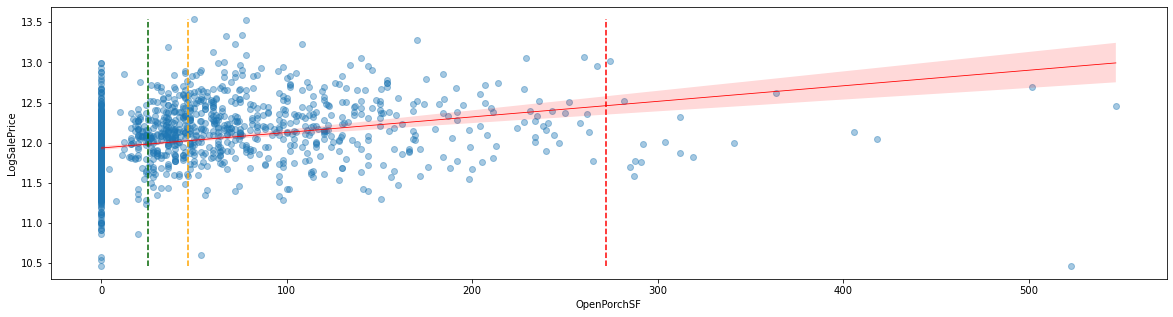

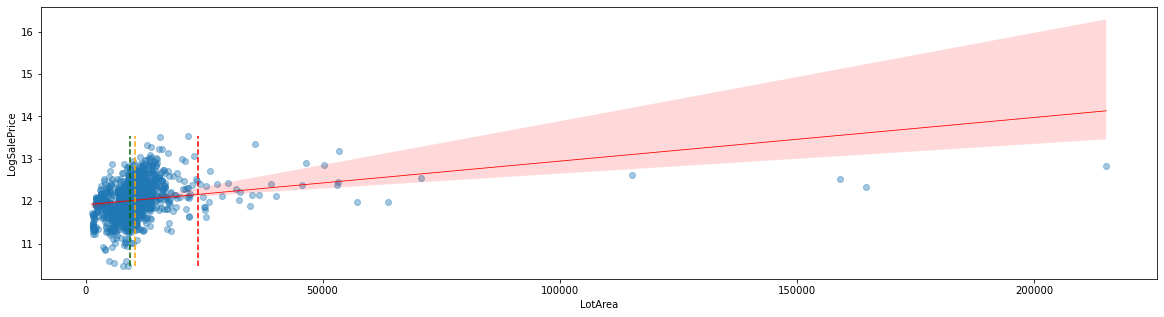

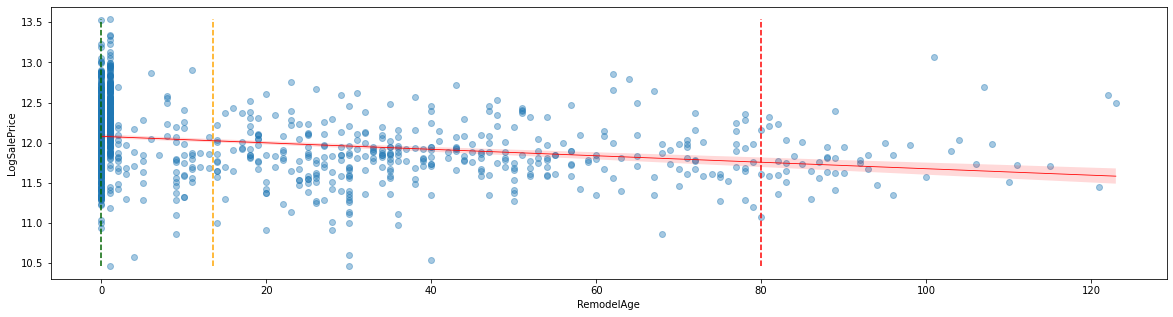

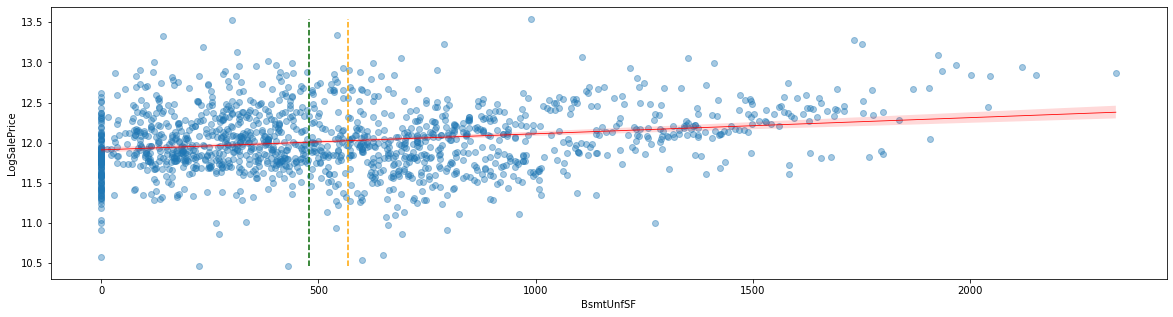

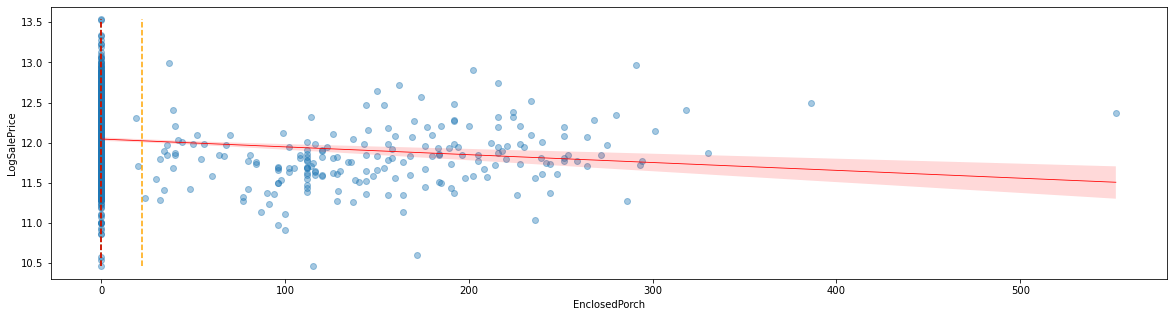

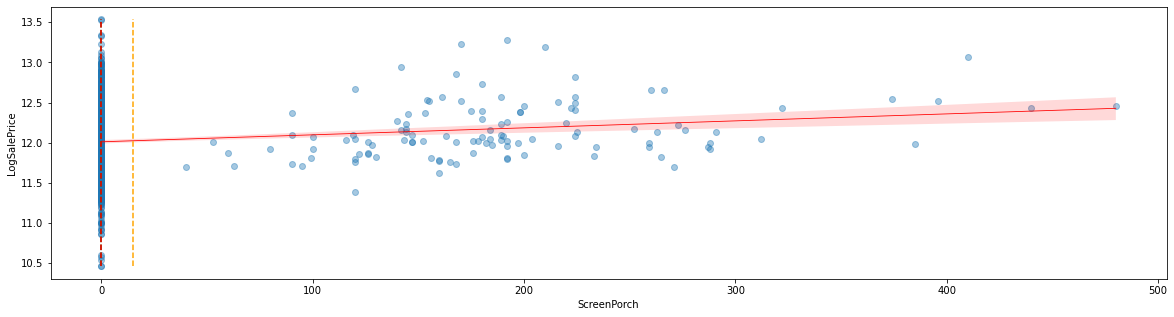

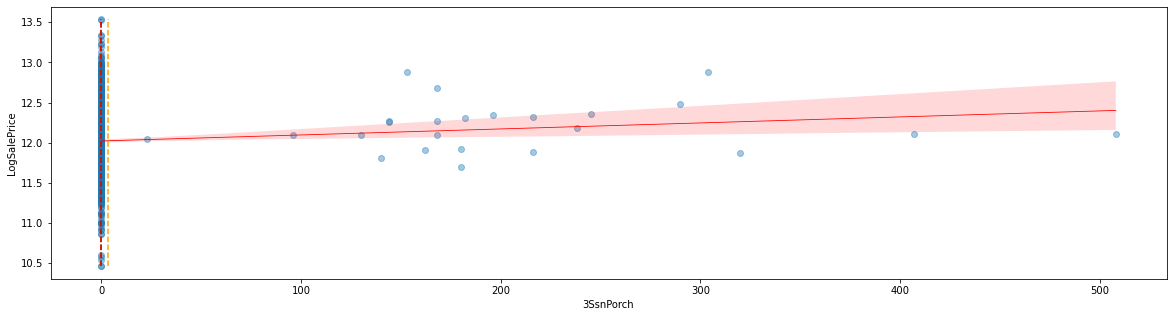

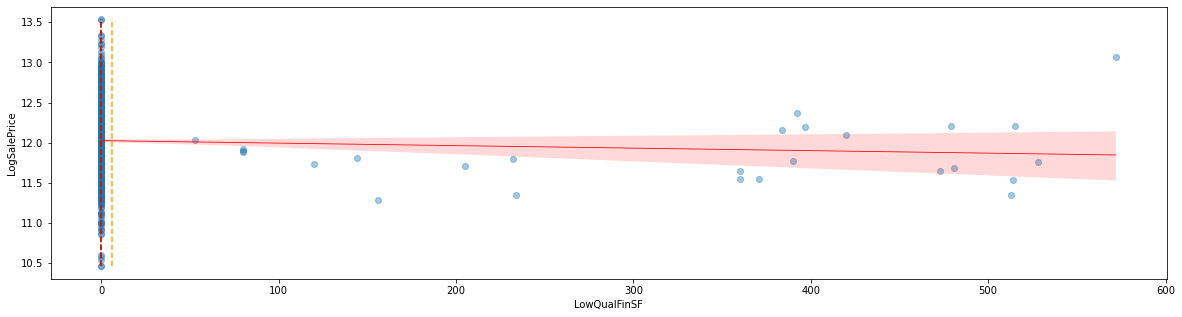

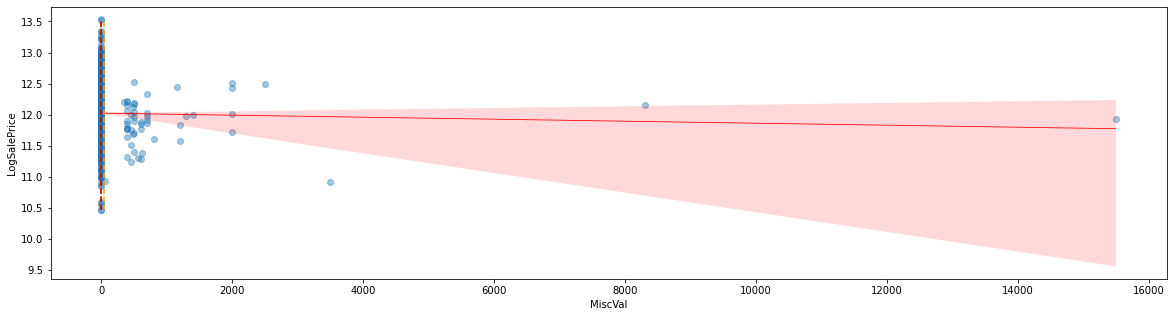

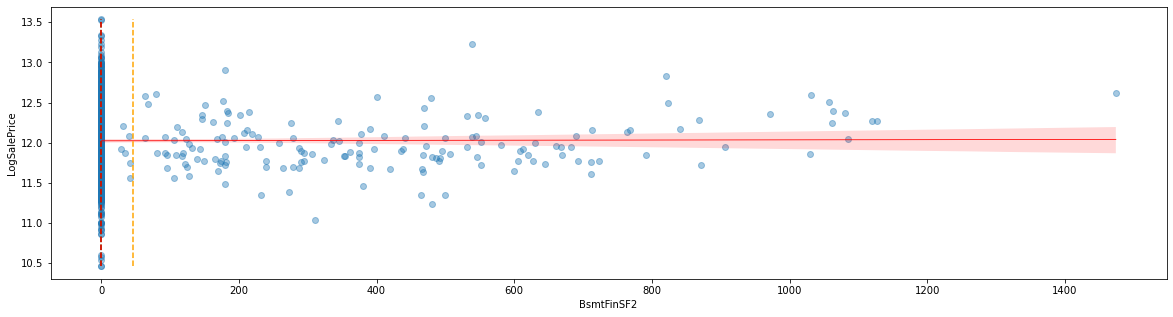

In [21]:
# Visually inspecting plots of each feature against LogSalePrice to look for outliers.
for feature in num_continuous:
    feature_plot(feature,'LogSalePrice')

In [22]:
train.drop(train[train['GrLivArea'] > 4500].index, inplace = True)
train.drop(train[train['TotalBsmtSF'] > 6000].index, inplace = True)
train.drop(train[train['1stFlrSF'] > 4500].index, inplace = True)
train.drop(train[train['MasVnrArea'] > 5000].index, inplace = True)
train.drop(train[train['BsmtFinSF1'] > 5000].index, inplace = True)
train.drop(train[train['LotFrontage'] > 300].index, inplace = True)
train.drop(train[train['WoodDeckSF'] > 650].index, inplace = True)
train.drop(train[train['OpenPorchSF'] > 520].index, inplace = True)
train.drop(train[train['LotArea'] > 100000].index, inplace = True)

In [23]:
# In both data sets, less than 1% of data was cleaned.
after_train = len(train)
diff_train = round((100*(before_train-after_train))/before_train,2)
print('      Training')
print('        Before: ' + str(before_train))
print('After cleaning: ' + str(after_train))
print('          Loss: ' + str(diff_train) + '%')
print('\n')

      Training
        Before: 1460
After cleaning: 1447
          Loss: 0.89%




# Dummying categorical features

In [70]:
# Join the two dataframes so that feature dummying is consistent across both sets of data.
temp = train.copy()
y = temp['LogSalePrice']
temp.drop('LogSalePrice', axis=1, inplace=True)
joined = pd.concat([temp,predict],axis = 0)
# Determine the index where the train section ends.
# This will be used to split the data back into train and predict later on.
train_end = len(train)
dummied = pd.get_dummies(joined, columns = categorical)
X = dummied.iloc[:train_end]
P = dummied.iloc[train_end:]

In [27]:
# The setup() and compare_models() commands from Pycaret will test the training set against multiple regressors
# and score each in multiple ways.
setup(data = train_final, target = 'LogSalePrice', numeric_features = num_list)

In [28]:
compare_models()

In [97]:
# The top 5 regressors are very close so it would be est to test each of them using cross validation.
# The data will be split into ten folds, producing ten scores. The mean and variance (as a % of the mean score) will
# help to determine which regressor to use.
# Regression scoring normally produces negative numbers as it measures the variance between the real and
# predicted targets, but also has to be scored with a larger number being better, producing a score between -1 and 0.
# To simplify this, 1 has been added to the scores so that it is the same as classifier scoring. i.e. 0 is a poor
# result and 1 is the best result.
from sklearn.linear_model import BayesianRidge
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge, OrthogonalMatchingPursuit
from sklearn.ensemble import GradientBoostingRegressor
Regressors = {'BayesianRidge':BayesianRidge, 'CatBoostRegressor':CatBoostRegressor, 'Ridge':Ridge, 'OrthogonalMatchingPursuit':OrthogonalMatchingPursuit, 'GradientBoostingRegressor':GradientBoostingRegressor}
results = pd.DataFrame([],index = Regressors.keys(), columns = ['Mean score','Variance (%)'])
for name, regressor in Regressors.items():
    reg = regressor()
    temp = cross_val_score(reg, X, y, scoring = 'neg_mean_squared_error', cv = KFold(n_splits = 10))
    val = 1+temp
    score = np.mean(val)
    var = np.std(val)
    pvar = (100*var)/score
    results.loc[name] = [np.round(score,5),np.round(pvar,2)]
results.sort_values('Mean score', ascending = False, inplace = True)

Learning rate set to 0.042686
0:	learn: 0.3884329	total: 5.33ms	remaining: 5.32s
1:	learn: 0.3785793	total: 6.98ms	remaining: 3.48s
2:	learn: 0.3679920	total: 19.5ms	remaining: 6.47s
3:	learn: 0.3575307	total: 23ms	remaining: 5.73s
4:	learn: 0.3484349	total: 25.2ms	remaining: 5.02s
5:	learn: 0.3389156	total: 29.1ms	remaining: 4.82s
6:	learn: 0.3302691	total: 32.5ms	remaining: 4.61s
7:	learn: 0.3221320	total: 33.7ms	remaining: 4.18s
8:	learn: 0.3140922	total: 34.9ms	remaining: 3.84s
9:	learn: 0.3064523	total: 36.1ms	remaining: 3.57s
10:	learn: 0.2994557	total: 37.3ms	remaining: 3.35s
11:	learn: 0.2930897	total: 38.5ms	remaining: 3.17s
12:	learn: 0.2863085	total: 39.7ms	remaining: 3.02s
13:	learn: 0.2795718	total: 40.9ms	remaining: 2.88s
14:	learn: 0.2739421	total: 42.1ms	remaining: 2.76s
15:	learn: 0.2677939	total: 43.3ms	remaining: 2.66s
16:	learn: 0.2622405	total: 44.4ms	remaining: 2.57s
17:	learn: 0.2573355	total: 45.6ms	remaining: 2.49s
18:	learn: 0.2516648	total: 46.8ms	remaining: 

280:	learn: 0.0792370	total: 386ms	remaining: 987ms
281:	learn: 0.0791346	total: 388ms	remaining: 987ms
282:	learn: 0.0789515	total: 389ms	remaining: 985ms
283:	learn: 0.0789353	total: 390ms	remaining: 984ms
284:	learn: 0.0788053	total: 391ms	remaining: 982ms
285:	learn: 0.0786666	total: 393ms	remaining: 980ms
286:	learn: 0.0785354	total: 394ms	remaining: 980ms
287:	learn: 0.0783940	total: 396ms	remaining: 978ms
288:	learn: 0.0783083	total: 397ms	remaining: 977ms
289:	learn: 0.0782256	total: 399ms	remaining: 976ms
290:	learn: 0.0781565	total: 400ms	remaining: 974ms
291:	learn: 0.0780276	total: 401ms	remaining: 973ms
292:	learn: 0.0780120	total: 402ms	remaining: 971ms
293:	learn: 0.0779776	total: 404ms	remaining: 969ms
294:	learn: 0.0778486	total: 405ms	remaining: 968ms
295:	learn: 0.0778331	total: 406ms	remaining: 966ms
296:	learn: 0.0777885	total: 407ms	remaining: 964ms
297:	learn: 0.0777103	total: 409ms	remaining: 963ms
298:	learn: 0.0775665	total: 410ms	remaining: 961ms
299:	learn: 

580:	learn: 0.0559087	total: 772ms	remaining: 557ms
581:	learn: 0.0558107	total: 774ms	remaining: 556ms
582:	learn: 0.0557336	total: 775ms	remaining: 554ms
583:	learn: 0.0556437	total: 776ms	remaining: 553ms
584:	learn: 0.0556382	total: 777ms	remaining: 551ms
585:	learn: 0.0556259	total: 778ms	remaining: 550ms
586:	learn: 0.0555473	total: 780ms	remaining: 549ms
587:	learn: 0.0554667	total: 781ms	remaining: 547ms
588:	learn: 0.0554189	total: 784ms	remaining: 547ms
589:	learn: 0.0554077	total: 785ms	remaining: 546ms
590:	learn: 0.0553361	total: 786ms	remaining: 544ms
591:	learn: 0.0551955	total: 788ms	remaining: 543ms
592:	learn: 0.0550899	total: 789ms	remaining: 541ms
593:	learn: 0.0550265	total: 790ms	remaining: 540ms
594:	learn: 0.0549651	total: 791ms	remaining: 539ms
595:	learn: 0.0549191	total: 792ms	remaining: 537ms
596:	learn: 0.0548974	total: 794ms	remaining: 536ms
597:	learn: 0.0548156	total: 795ms	remaining: 534ms
598:	learn: 0.0547709	total: 796ms	remaining: 533ms
599:	learn: 

890:	learn: 0.0408513	total: 1.16s	remaining: 142ms
891:	learn: 0.0408190	total: 1.16s	remaining: 140ms
892:	learn: 0.0407679	total: 1.16s	remaining: 139ms
893:	learn: 0.0407289	total: 1.16s	remaining: 138ms
894:	learn: 0.0407253	total: 1.16s	remaining: 136ms
895:	learn: 0.0407226	total: 1.16s	remaining: 135ms
896:	learn: 0.0407178	total: 1.16s	remaining: 134ms
897:	learn: 0.0406940	total: 1.17s	remaining: 132ms
898:	learn: 0.0406223	total: 1.17s	remaining: 131ms
899:	learn: 0.0405809	total: 1.17s	remaining: 130ms
900:	learn: 0.0405214	total: 1.17s	remaining: 129ms
901:	learn: 0.0404493	total: 1.17s	remaining: 127ms
902:	learn: 0.0404201	total: 1.17s	remaining: 126ms
903:	learn: 0.0404169	total: 1.17s	remaining: 125ms
904:	learn: 0.0403587	total: 1.17s	remaining: 123ms
905:	learn: 0.0403127	total: 1.18s	remaining: 122ms
906:	learn: 0.0403087	total: 1.18s	remaining: 121ms
907:	learn: 0.0402574	total: 1.18s	remaining: 119ms
908:	learn: 0.0402359	total: 1.18s	remaining: 118ms
909:	learn: 

160:	learn: 0.0975880	total: 200ms	remaining: 1.04s
161:	learn: 0.0974702	total: 201ms	remaining: 1.04s
162:	learn: 0.0973185	total: 202ms	remaining: 1.04s
163:	learn: 0.0971473	total: 204ms	remaining: 1.04s
164:	learn: 0.0969833	total: 205ms	remaining: 1.04s
165:	learn: 0.0968277	total: 206ms	remaining: 1.03s
166:	learn: 0.0966605	total: 207ms	remaining: 1.03s
167:	learn: 0.0965242	total: 209ms	remaining: 1.03s
168:	learn: 0.0963653	total: 210ms	remaining: 1.03s
169:	learn: 0.0961497	total: 211ms	remaining: 1.03s
170:	learn: 0.0959897	total: 212ms	remaining: 1.03s
171:	learn: 0.0957670	total: 214ms	remaining: 1.03s
172:	learn: 0.0955295	total: 215ms	remaining: 1.02s
173:	learn: 0.0954137	total: 216ms	remaining: 1.02s
174:	learn: 0.0952623	total: 217ms	remaining: 1.02s
175:	learn: 0.0950897	total: 218ms	remaining: 1.02s
176:	learn: 0.0948969	total: 219ms	remaining: 1.02s
177:	learn: 0.0947114	total: 221ms	remaining: 1.02s
178:	learn: 0.0945641	total: 222ms	remaining: 1.02s
179:	learn: 

327:	learn: 0.0752207	total: 393ms	remaining: 805ms
328:	learn: 0.0752064	total: 394ms	remaining: 803ms
329:	learn: 0.0751084	total: 395ms	remaining: 802ms
330:	learn: 0.0749479	total: 396ms	remaining: 801ms
331:	learn: 0.0749302	total: 398ms	remaining: 801ms
332:	learn: 0.0748390	total: 399ms	remaining: 800ms
333:	learn: 0.0746942	total: 400ms	remaining: 798ms
334:	learn: 0.0746343	total: 401ms	remaining: 797ms
335:	learn: 0.0745352	total: 403ms	remaining: 797ms
336:	learn: 0.0744642	total: 404ms	remaining: 796ms
337:	learn: 0.0743491	total: 405ms	remaining: 794ms
338:	learn: 0.0743331	total: 407ms	remaining: 793ms
339:	learn: 0.0742362	total: 408ms	remaining: 792ms
340:	learn: 0.0740784	total: 409ms	remaining: 790ms
341:	learn: 0.0739834	total: 410ms	remaining: 789ms
342:	learn: 0.0738037	total: 411ms	remaining: 788ms
343:	learn: 0.0737884	total: 413ms	remaining: 787ms
344:	learn: 0.0737152	total: 414ms	remaining: 785ms
345:	learn: 0.0736036	total: 415ms	remaining: 784ms
346:	learn: 

494:	learn: 0.0621921	total: 585ms	remaining: 597ms
495:	learn: 0.0621016	total: 587ms	remaining: 596ms
496:	learn: 0.0620085	total: 588ms	remaining: 595ms
497:	learn: 0.0619094	total: 589ms	remaining: 594ms
498:	learn: 0.0618603	total: 591ms	remaining: 593ms
499:	learn: 0.0617962	total: 592ms	remaining: 592ms
500:	learn: 0.0617187	total: 593ms	remaining: 591ms
501:	learn: 0.0616254	total: 595ms	remaining: 590ms
502:	learn: 0.0615671	total: 597ms	remaining: 590ms
503:	learn: 0.0614745	total: 598ms	remaining: 589ms
504:	learn: 0.0614610	total: 601ms	remaining: 589ms
505:	learn: 0.0614084	total: 603ms	remaining: 588ms
506:	learn: 0.0613688	total: 604ms	remaining: 587ms
507:	learn: 0.0613064	total: 605ms	remaining: 586ms
508:	learn: 0.0612306	total: 607ms	remaining: 585ms
509:	learn: 0.0612170	total: 608ms	remaining: 584ms
510:	learn: 0.0611770	total: 610ms	remaining: 583ms
511:	learn: 0.0610894	total: 611ms	remaining: 582ms
512:	learn: 0.0610474	total: 612ms	remaining: 581ms
513:	learn: 

800:	learn: 0.0447022	total: 973ms	remaining: 242ms
801:	learn: 0.0446640	total: 974ms	remaining: 240ms
802:	learn: 0.0445582	total: 975ms	remaining: 239ms
803:	learn: 0.0445081	total: 977ms	remaining: 238ms
804:	learn: 0.0444708	total: 978ms	remaining: 237ms
805:	learn: 0.0444416	total: 980ms	remaining: 236ms
806:	learn: 0.0443926	total: 981ms	remaining: 235ms
807:	learn: 0.0443606	total: 982ms	remaining: 233ms
808:	learn: 0.0443453	total: 983ms	remaining: 232ms
809:	learn: 0.0443079	total: 984ms	remaining: 231ms
810:	learn: 0.0442845	total: 986ms	remaining: 230ms
811:	learn: 0.0442141	total: 987ms	remaining: 229ms
812:	learn: 0.0441687	total: 989ms	remaining: 227ms
813:	learn: 0.0441103	total: 990ms	remaining: 226ms
814:	learn: 0.0441055	total: 991ms	remaining: 225ms
815:	learn: 0.0440502	total: 992ms	remaining: 224ms
816:	learn: 0.0440081	total: 993ms	remaining: 222ms
817:	learn: 0.0439523	total: 994ms	remaining: 221ms
818:	learn: 0.0439063	total: 995ms	remaining: 220ms
819:	learn: 

960:	learn: 0.0380351	total: 1.17s	remaining: 47.3ms
961:	learn: 0.0380194	total: 1.17s	remaining: 46.1ms
962:	learn: 0.0379922	total: 1.17s	remaining: 45ms
963:	learn: 0.0379295	total: 1.17s	remaining: 43.8ms
964:	learn: 0.0379245	total: 1.18s	remaining: 42.6ms
965:	learn: 0.0378479	total: 1.18s	remaining: 41.4ms
966:	learn: 0.0377905	total: 1.18s	remaining: 40.2ms
967:	learn: 0.0377721	total: 1.18s	remaining: 39ms
968:	learn: 0.0377300	total: 1.18s	remaining: 37.8ms
969:	learn: 0.0376735	total: 1.18s	remaining: 36.6ms
970:	learn: 0.0376402	total: 1.18s	remaining: 35.4ms
971:	learn: 0.0375996	total: 1.19s	remaining: 34.2ms
972:	learn: 0.0375560	total: 1.19s	remaining: 32.9ms
973:	learn: 0.0375517	total: 1.19s	remaining: 31.7ms
974:	learn: 0.0375070	total: 1.19s	remaining: 30.5ms
975:	learn: 0.0374712	total: 1.19s	remaining: 29.3ms
976:	learn: 0.0374427	total: 1.19s	remaining: 28.1ms
977:	learn: 0.0374167	total: 1.19s	remaining: 26.9ms
978:	learn: 0.0374040	total: 1.2s	remaining: 25.6m

214:	learn: 0.0887342	total: 281ms	remaining: 1.02s
215:	learn: 0.0885904	total: 282ms	remaining: 1.02s
216:	learn: 0.0883985	total: 284ms	remaining: 1.02s
217:	learn: 0.0882125	total: 285ms	remaining: 1.02s
218:	learn: 0.0881415	total: 286ms	remaining: 1.02s
219:	learn: 0.0879818	total: 287ms	remaining: 1.02s
220:	learn: 0.0879299	total: 289ms	remaining: 1.02s
221:	learn: 0.0878168	total: 290ms	remaining: 1.02s
222:	learn: 0.0877644	total: 291ms	remaining: 1.01s
223:	learn: 0.0876871	total: 293ms	remaining: 1.01s
224:	learn: 0.0875502	total: 294ms	remaining: 1.01s
225:	learn: 0.0873672	total: 295ms	remaining: 1.01s
226:	learn: 0.0872550	total: 296ms	remaining: 1.01s
227:	learn: 0.0871899	total: 297ms	remaining: 1.01s
228:	learn: 0.0870738	total: 299ms	remaining: 1s
229:	learn: 0.0868738	total: 300ms	remaining: 1s
230:	learn: 0.0867255	total: 302ms	remaining: 1s
231:	learn: 0.0866024	total: 303ms	remaining: 1s
232:	learn: 0.0864968	total: 304ms	remaining: 1000ms
233:	learn: 0.0863458	t

523:	learn: 0.0611923	total: 665ms	remaining: 604ms
524:	learn: 0.0611078	total: 666ms	remaining: 603ms
525:	learn: 0.0610402	total: 668ms	remaining: 602ms
526:	learn: 0.0609993	total: 669ms	remaining: 601ms
527:	learn: 0.0609200	total: 671ms	remaining: 600ms
528:	learn: 0.0609131	total: 672ms	remaining: 599ms
529:	learn: 0.0608470	total: 674ms	remaining: 597ms
530:	learn: 0.0607199	total: 675ms	remaining: 596ms
531:	learn: 0.0606471	total: 676ms	remaining: 595ms
532:	learn: 0.0605777	total: 678ms	remaining: 594ms
533:	learn: 0.0604869	total: 679ms	remaining: 593ms
534:	learn: 0.0604053	total: 680ms	remaining: 591ms
535:	learn: 0.0603999	total: 682ms	remaining: 590ms
536:	learn: 0.0603467	total: 683ms	remaining: 589ms
537:	learn: 0.0602848	total: 685ms	remaining: 588ms
538:	learn: 0.0601711	total: 687ms	remaining: 587ms
539:	learn: 0.0601641	total: 689ms	remaining: 587ms
540:	learn: 0.0601584	total: 690ms	remaining: 586ms
541:	learn: 0.0600788	total: 692ms	remaining: 584ms
542:	learn: 

807:	learn: 0.0451201	total: 1.05s	remaining: 250ms
808:	learn: 0.0450603	total: 1.05s	remaining: 248ms
809:	learn: 0.0449920	total: 1.05s	remaining: 247ms
810:	learn: 0.0449820	total: 1.05s	remaining: 246ms
811:	learn: 0.0449218	total: 1.06s	remaining: 245ms
812:	learn: 0.0449181	total: 1.06s	remaining: 243ms
813:	learn: 0.0448997	total: 1.06s	remaining: 242ms
814:	learn: 0.0448730	total: 1.06s	remaining: 241ms
815:	learn: 0.0448291	total: 1.06s	remaining: 239ms
816:	learn: 0.0447716	total: 1.06s	remaining: 238ms
817:	learn: 0.0447096	total: 1.06s	remaining: 237ms
818:	learn: 0.0446776	total: 1.06s	remaining: 235ms
819:	learn: 0.0446089	total: 1.07s	remaining: 234ms
820:	learn: 0.0445218	total: 1.07s	remaining: 233ms
821:	learn: 0.0444664	total: 1.07s	remaining: 231ms
822:	learn: 0.0444146	total: 1.07s	remaining: 230ms
823:	learn: 0.0443706	total: 1.07s	remaining: 229ms
824:	learn: 0.0443198	total: 1.07s	remaining: 227ms
825:	learn: 0.0442769	total: 1.07s	remaining: 226ms
826:	learn: 

52:	learn: 0.1496191	total: 77ms	remaining: 1.38s
53:	learn: 0.1480745	total: 78.5ms	remaining: 1.38s
54:	learn: 0.1466664	total: 80ms	remaining: 1.38s
55:	learn: 0.1454101	total: 81.3ms	remaining: 1.37s
56:	learn: 0.1439380	total: 82.7ms	remaining: 1.37s
57:	learn: 0.1427005	total: 84.3ms	remaining: 1.37s
58:	learn: 0.1415401	total: 85.7ms	remaining: 1.37s
59:	learn: 0.1403590	total: 87.1ms	remaining: 1.36s
60:	learn: 0.1391954	total: 88.9ms	remaining: 1.37s
61:	learn: 0.1379410	total: 90.4ms	remaining: 1.37s
62:	learn: 0.1367043	total: 91.8ms	remaining: 1.36s
63:	learn: 0.1355918	total: 93.3ms	remaining: 1.36s
64:	learn: 0.1346018	total: 94.6ms	remaining: 1.36s
65:	learn: 0.1335583	total: 95.9ms	remaining: 1.36s
66:	learn: 0.1325545	total: 97.3ms	remaining: 1.35s
67:	learn: 0.1317244	total: 98.6ms	remaining: 1.35s
68:	learn: 0.1307411	total: 100ms	remaining: 1.35s
69:	learn: 0.1300516	total: 102ms	remaining: 1.35s
70:	learn: 0.1292523	total: 103ms	remaining: 1.34s
71:	learn: 0.128437

366:	learn: 0.0702178	total: 464ms	remaining: 800ms
367:	learn: 0.0702029	total: 465ms	remaining: 799ms
368:	learn: 0.0701280	total: 466ms	remaining: 797ms
369:	learn: 0.0699970	total: 467ms	remaining: 796ms
370:	learn: 0.0698959	total: 469ms	remaining: 795ms
371:	learn: 0.0697809	total: 471ms	remaining: 796ms
372:	learn: 0.0697632	total: 473ms	remaining: 795ms
373:	learn: 0.0697433	total: 474ms	remaining: 794ms
374:	learn: 0.0697230	total: 476ms	remaining: 793ms
375:	learn: 0.0695853	total: 477ms	remaining: 792ms
376:	learn: 0.0695007	total: 478ms	remaining: 790ms
377:	learn: 0.0694354	total: 479ms	remaining: 789ms
378:	learn: 0.0693903	total: 481ms	remaining: 787ms
379:	learn: 0.0693324	total: 482ms	remaining: 786ms
380:	learn: 0.0692161	total: 483ms	remaining: 785ms
381:	learn: 0.0691465	total: 484ms	remaining: 783ms
382:	learn: 0.0690357	total: 485ms	remaining: 782ms
383:	learn: 0.0689271	total: 486ms	remaining: 780ms
384:	learn: 0.0688553	total: 488ms	remaining: 779ms
385:	learn: 

532:	learn: 0.0577311	total: 657ms	remaining: 575ms
533:	learn: 0.0576439	total: 658ms	remaining: 574ms
534:	learn: 0.0575758	total: 659ms	remaining: 573ms
535:	learn: 0.0575267	total: 661ms	remaining: 572ms
536:	learn: 0.0574904	total: 662ms	remaining: 570ms
537:	learn: 0.0573589	total: 663ms	remaining: 569ms
538:	learn: 0.0573411	total: 664ms	remaining: 568ms
539:	learn: 0.0572886	total: 665ms	remaining: 566ms
540:	learn: 0.0572554	total: 666ms	remaining: 565ms
541:	learn: 0.0572472	total: 667ms	remaining: 564ms
542:	learn: 0.0571653	total: 668ms	remaining: 562ms
543:	learn: 0.0570677	total: 670ms	remaining: 561ms
544:	learn: 0.0570590	total: 671ms	remaining: 560ms
545:	learn: 0.0569926	total: 672ms	remaining: 559ms
546:	learn: 0.0569313	total: 673ms	remaining: 557ms
547:	learn: 0.0568604	total: 674ms	remaining: 556ms
548:	learn: 0.0567425	total: 676ms	remaining: 555ms
549:	learn: 0.0566319	total: 677ms	remaining: 554ms
550:	learn: 0.0565484	total: 678ms	remaining: 553ms
551:	learn: 

698:	learn: 0.0480176	total: 849ms	remaining: 366ms
699:	learn: 0.0479538	total: 851ms	remaining: 365ms
700:	learn: 0.0479074	total: 852ms	remaining: 363ms
701:	learn: 0.0478352	total: 853ms	remaining: 362ms
702:	learn: 0.0477840	total: 854ms	remaining: 361ms
703:	learn: 0.0477205	total: 856ms	remaining: 360ms
704:	learn: 0.0476735	total: 857ms	remaining: 359ms
705:	learn: 0.0476335	total: 858ms	remaining: 357ms
706:	learn: 0.0475492	total: 859ms	remaining: 356ms
707:	learn: 0.0475095	total: 860ms	remaining: 355ms
708:	learn: 0.0474912	total: 862ms	remaining: 354ms
709:	learn: 0.0474439	total: 863ms	remaining: 353ms
710:	learn: 0.0474235	total: 865ms	remaining: 352ms
711:	learn: 0.0473548	total: 866ms	remaining: 350ms
712:	learn: 0.0472907	total: 868ms	remaining: 349ms
713:	learn: 0.0472144	total: 869ms	remaining: 348ms
714:	learn: 0.0471061	total: 870ms	remaining: 347ms
715:	learn: 0.0470137	total: 872ms	remaining: 346ms
716:	learn: 0.0469734	total: 873ms	remaining: 345ms
717:	learn: 

959:	learn: 0.0363776	total: 1.25s	remaining: 51.9ms
960:	learn: 0.0363502	total: 1.25s	remaining: 50.6ms
961:	learn: 0.0363287	total: 1.25s	remaining: 49.3ms
962:	learn: 0.0363121	total: 1.25s	remaining: 48ms
963:	learn: 0.0362800	total: 1.25s	remaining: 46.7ms
964:	learn: 0.0362217	total: 1.25s	remaining: 45.5ms
965:	learn: 0.0361837	total: 1.25s	remaining: 44.2ms
966:	learn: 0.0361365	total: 1.26s	remaining: 42.9ms
967:	learn: 0.0361177	total: 1.26s	remaining: 41.6ms
968:	learn: 0.0360722	total: 1.26s	remaining: 40.3ms
969:	learn: 0.0360215	total: 1.26s	remaining: 39ms
970:	learn: 0.0359968	total: 1.26s	remaining: 37.7ms
971:	learn: 0.0359930	total: 1.26s	remaining: 36.4ms
972:	learn: 0.0359683	total: 1.26s	remaining: 35.1ms
973:	learn: 0.0359130	total: 1.26s	remaining: 33.8ms
974:	learn: 0.0358841	total: 1.27s	remaining: 32.5ms
975:	learn: 0.0358461	total: 1.27s	remaining: 31.2ms
976:	learn: 0.0358076	total: 1.27s	remaining: 29.9ms
977:	learn: 0.0357845	total: 1.27s	remaining: 28.6

178:	learn: 0.0910395	total: 278ms	remaining: 1.28s
179:	learn: 0.0908841	total: 280ms	remaining: 1.27s
180:	learn: 0.0906915	total: 281ms	remaining: 1.27s
181:	learn: 0.0905365	total: 283ms	remaining: 1.27s
182:	learn: 0.0903108	total: 284ms	remaining: 1.27s
183:	learn: 0.0901241	total: 286ms	remaining: 1.27s
184:	learn: 0.0899068	total: 287ms	remaining: 1.26s
185:	learn: 0.0897111	total: 289ms	remaining: 1.26s
186:	learn: 0.0895516	total: 290ms	remaining: 1.26s
187:	learn: 0.0894089	total: 291ms	remaining: 1.26s
188:	learn: 0.0892719	total: 292ms	remaining: 1.25s
189:	learn: 0.0891384	total: 294ms	remaining: 1.25s
190:	learn: 0.0890024	total: 295ms	remaining: 1.25s
191:	learn: 0.0888379	total: 297ms	remaining: 1.25s
192:	learn: 0.0886899	total: 299ms	remaining: 1.25s
193:	learn: 0.0885476	total: 301ms	remaining: 1.25s
194:	learn: 0.0883829	total: 302ms	remaining: 1.25s
195:	learn: 0.0882235	total: 304ms	remaining: 1.25s
196:	learn: 0.0880308	total: 305ms	remaining: 1.24s
197:	learn: 

433:	learn: 0.0622297	total: 666ms	remaining: 869ms
434:	learn: 0.0621510	total: 668ms	remaining: 868ms
435:	learn: 0.0620688	total: 669ms	remaining: 866ms
436:	learn: 0.0620575	total: 671ms	remaining: 864ms
437:	learn: 0.0619772	total: 672ms	remaining: 862ms
438:	learn: 0.0619668	total: 673ms	remaining: 861ms
439:	learn: 0.0619189	total: 675ms	remaining: 859ms
440:	learn: 0.0618786	total: 677ms	remaining: 858ms
441:	learn: 0.0618072	total: 678ms	remaining: 857ms
442:	learn: 0.0616881	total: 680ms	remaining: 855ms
443:	learn: 0.0615485	total: 682ms	remaining: 854ms
444:	learn: 0.0614744	total: 683ms	remaining: 852ms
445:	learn: 0.0613354	total: 685ms	remaining: 851ms
446:	learn: 0.0612834	total: 686ms	remaining: 849ms
447:	learn: 0.0612686	total: 688ms	remaining: 848ms
448:	learn: 0.0611755	total: 689ms	remaining: 846ms
449:	learn: 0.0611178	total: 691ms	remaining: 844ms
450:	learn: 0.0610292	total: 692ms	remaining: 843ms
451:	learn: 0.0609463	total: 694ms	remaining: 841ms
452:	learn: 

645:	learn: 0.0484610	total: 1.05s	remaining: 578ms
646:	learn: 0.0483974	total: 1.06s	remaining: 576ms
647:	learn: 0.0483409	total: 1.06s	remaining: 575ms
648:	learn: 0.0482905	total: 1.06s	remaining: 573ms
649:	learn: 0.0482249	total: 1.06s	remaining: 572ms
650:	learn: 0.0481404	total: 1.06s	remaining: 570ms
651:	learn: 0.0480907	total: 1.06s	remaining: 568ms
652:	learn: 0.0480403	total: 1.07s	remaining: 567ms
653:	learn: 0.0479467	total: 1.07s	remaining: 565ms
654:	learn: 0.0478884	total: 1.07s	remaining: 564ms
655:	learn: 0.0478566	total: 1.07s	remaining: 562ms
656:	learn: 0.0478025	total: 1.07s	remaining: 560ms
657:	learn: 0.0477220	total: 1.07s	remaining: 559ms
658:	learn: 0.0476489	total: 1.08s	remaining: 557ms
659:	learn: 0.0476207	total: 1.08s	remaining: 555ms
660:	learn: 0.0475805	total: 1.08s	remaining: 553ms
661:	learn: 0.0475488	total: 1.08s	remaining: 552ms
662:	learn: 0.0475091	total: 1.08s	remaining: 550ms
663:	learn: 0.0474364	total: 1.08s	remaining: 548ms
664:	learn: 

911:	learn: 0.0359366	total: 1.44s	remaining: 139ms
912:	learn: 0.0358910	total: 1.44s	remaining: 138ms
913:	learn: 0.0358408	total: 1.45s	remaining: 136ms
914:	learn: 0.0357937	total: 1.45s	remaining: 134ms
915:	learn: 0.0357682	total: 1.45s	remaining: 133ms
916:	learn: 0.0357257	total: 1.45s	remaining: 131ms
917:	learn: 0.0356729	total: 1.45s	remaining: 130ms
918:	learn: 0.0356337	total: 1.45s	remaining: 128ms
919:	learn: 0.0355896	total: 1.45s	remaining: 126ms
920:	learn: 0.0355456	total: 1.45s	remaining: 125ms
921:	learn: 0.0355278	total: 1.46s	remaining: 123ms
922:	learn: 0.0355038	total: 1.46s	remaining: 122ms
923:	learn: 0.0354855	total: 1.46s	remaining: 120ms
924:	learn: 0.0354379	total: 1.46s	remaining: 118ms
925:	learn: 0.0353810	total: 1.46s	remaining: 117ms
926:	learn: 0.0353455	total: 1.46s	remaining: 115ms
927:	learn: 0.0353068	total: 1.46s	remaining: 114ms
928:	learn: 0.0352715	total: 1.46s	remaining: 112ms
929:	learn: 0.0352498	total: 1.47s	remaining: 110ms
930:	learn: 

158:	learn: 0.0988501	total: 217ms	remaining: 1.15s
159:	learn: 0.0986625	total: 219ms	remaining: 1.15s
160:	learn: 0.0985282	total: 220ms	remaining: 1.15s
161:	learn: 0.0983127	total: 221ms	remaining: 1.14s
162:	learn: 0.0981429	total: 222ms	remaining: 1.14s
163:	learn: 0.0979686	total: 223ms	remaining: 1.14s
164:	learn: 0.0977502	total: 224ms	remaining: 1.14s
165:	learn: 0.0974638	total: 226ms	remaining: 1.13s
166:	learn: 0.0973441	total: 227ms	remaining: 1.13s
167:	learn: 0.0971660	total: 228ms	remaining: 1.13s
168:	learn: 0.0968781	total: 229ms	remaining: 1.13s
169:	learn: 0.0966824	total: 231ms	remaining: 1.13s
170:	learn: 0.0965696	total: 232ms	remaining: 1.12s
171:	learn: 0.0962701	total: 234ms	remaining: 1.13s
172:	learn: 0.0960843	total: 235ms	remaining: 1.12s
173:	learn: 0.0958730	total: 236ms	remaining: 1.12s
174:	learn: 0.0956883	total: 238ms	remaining: 1.12s
175:	learn: 0.0954952	total: 240ms	remaining: 1.13s
176:	learn: 0.0953043	total: 242ms	remaining: 1.12s
177:	learn: 

453:	learn: 0.0643156	total: 602ms	remaining: 724ms
454:	learn: 0.0642100	total: 603ms	remaining: 723ms
455:	learn: 0.0641771	total: 605ms	remaining: 721ms
456:	learn: 0.0641083	total: 606ms	remaining: 720ms
457:	learn: 0.0640988	total: 607ms	remaining: 718ms
458:	learn: 0.0639874	total: 608ms	remaining: 717ms
459:	learn: 0.0638724	total: 609ms	remaining: 715ms
460:	learn: 0.0637644	total: 611ms	remaining: 714ms
461:	learn: 0.0637397	total: 612ms	remaining: 713ms
462:	learn: 0.0636414	total: 614ms	remaining: 712ms
463:	learn: 0.0635596	total: 615ms	remaining: 710ms
464:	learn: 0.0634491	total: 616ms	remaining: 709ms
465:	learn: 0.0632700	total: 618ms	remaining: 708ms
466:	learn: 0.0632049	total: 619ms	remaining: 706ms
467:	learn: 0.0631906	total: 620ms	remaining: 705ms
468:	learn: 0.0630683	total: 621ms	remaining: 703ms
469:	learn: 0.0629697	total: 623ms	remaining: 702ms
470:	learn: 0.0628819	total: 624ms	remaining: 701ms
471:	learn: 0.0627663	total: 627ms	remaining: 701ms
472:	learn: 

735:	learn: 0.0465644	total: 987ms	remaining: 354ms
736:	learn: 0.0465570	total: 989ms	remaining: 353ms
737:	learn: 0.0464798	total: 990ms	remaining: 351ms
738:	learn: 0.0463980	total: 991ms	remaining: 350ms
739:	learn: 0.0463769	total: 992ms	remaining: 349ms
740:	learn: 0.0463233	total: 993ms	remaining: 347ms
741:	learn: 0.0462802	total: 995ms	remaining: 346ms
742:	learn: 0.0461945	total: 996ms	remaining: 344ms
743:	learn: 0.0461358	total: 997ms	remaining: 343ms
744:	learn: 0.0460862	total: 998ms	remaining: 342ms
745:	learn: 0.0460617	total: 999ms	remaining: 340ms
746:	learn: 0.0460293	total: 1s	remaining: 339ms
747:	learn: 0.0459593	total: 1s	remaining: 337ms
748:	learn: 0.0459550	total: 1s	remaining: 336ms
749:	learn: 0.0458860	total: 1s	remaining: 335ms
750:	learn: 0.0458433	total: 1s	remaining: 333ms
751:	learn: 0.0458364	total: 1.01s	remaining: 332ms
752:	learn: 0.0457792	total: 1.01s	remaining: 330ms
753:	learn: 0.0457599	total: 1.01s	remaining: 329ms
754:	learn: 0.0457458	total

Learning rate set to 0.042686
0:	learn: 0.3862583	total: 2.93ms	remaining: 2.92s
1:	learn: 0.3755512	total: 4.45ms	remaining: 2.22s
2:	learn: 0.3660191	total: 7.41ms	remaining: 2.46s
3:	learn: 0.3556019	total: 8.8ms	remaining: 2.19s
4:	learn: 0.3463809	total: 10.1ms	remaining: 2.02s
5:	learn: 0.3381129	total: 11.3ms	remaining: 1.87s
6:	learn: 0.3289034	total: 12.4ms	remaining: 1.76s
7:	learn: 0.3205271	total: 13.8ms	remaining: 1.71s
8:	learn: 0.3123951	total: 15ms	remaining: 1.65s
9:	learn: 0.3042880	total: 16.3ms	remaining: 1.61s
10:	learn: 0.2968600	total: 17.5ms	remaining: 1.57s
11:	learn: 0.2899507	total: 18.6ms	remaining: 1.53s
12:	learn: 0.2827381	total: 19.7ms	remaining: 1.5s
13:	learn: 0.2762445	total: 20.9ms	remaining: 1.47s
14:	learn: 0.2698466	total: 22.6ms	remaining: 1.48s
15:	learn: 0.2635850	total: 23.8ms	remaining: 1.46s
16:	learn: 0.2582663	total: 24.9ms	remaining: 1.44s
17:	learn: 0.2527146	total: 26.2ms	remaining: 1.43s
18:	learn: 0.2476450	total: 27.5ms	remaining: 1.

283:	learn: 0.0803167	total: 387ms	remaining: 975ms
284:	learn: 0.0801413	total: 388ms	remaining: 973ms
285:	learn: 0.0799685	total: 389ms	remaining: 972ms
286:	learn: 0.0797639	total: 391ms	remaining: 970ms
287:	learn: 0.0796708	total: 392ms	remaining: 968ms
288:	learn: 0.0795526	total: 393ms	remaining: 967ms
289:	learn: 0.0794269	total: 394ms	remaining: 965ms
290:	learn: 0.0792785	total: 395ms	remaining: 963ms
291:	learn: 0.0792603	total: 396ms	remaining: 961ms
292:	learn: 0.0791562	total: 398ms	remaining: 961ms
293:	learn: 0.0789711	total: 399ms	remaining: 959ms
294:	learn: 0.0788602	total: 401ms	remaining: 957ms
295:	learn: 0.0787125	total: 402ms	remaining: 956ms
296:	learn: 0.0785917	total: 403ms	remaining: 954ms
297:	learn: 0.0784884	total: 404ms	remaining: 952ms
298:	learn: 0.0784702	total: 405ms	remaining: 950ms
299:	learn: 0.0783499	total: 407ms	remaining: 949ms
300:	learn: 0.0781975	total: 408ms	remaining: 947ms
301:	learn: 0.0780521	total: 409ms	remaining: 945ms
302:	learn: 

574:	learn: 0.0569822	total: 769ms	remaining: 569ms
575:	learn: 0.0569117	total: 770ms	remaining: 567ms
576:	learn: 0.0568451	total: 773ms	remaining: 567ms
577:	learn: 0.0567748	total: 774ms	remaining: 565ms
578:	learn: 0.0566812	total: 775ms	remaining: 564ms
579:	learn: 0.0565883	total: 777ms	remaining: 562ms
580:	learn: 0.0564848	total: 778ms	remaining: 561ms
581:	learn: 0.0564269	total: 780ms	remaining: 560ms
582:	learn: 0.0563781	total: 781ms	remaining: 558ms
583:	learn: 0.0562909	total: 782ms	remaining: 557ms
584:	learn: 0.0561779	total: 783ms	remaining: 556ms
585:	learn: 0.0561030	total: 786ms	remaining: 555ms
586:	learn: 0.0560331	total: 787ms	remaining: 554ms
587:	learn: 0.0559613	total: 789ms	remaining: 553ms
588:	learn: 0.0559157	total: 790ms	remaining: 551ms
589:	learn: 0.0558371	total: 791ms	remaining: 550ms
590:	learn: 0.0557548	total: 792ms	remaining: 548ms
591:	learn: 0.0556856	total: 794ms	remaining: 547ms
592:	learn: 0.0555880	total: 795ms	remaining: 546ms
593:	learn: 

886:	learn: 0.0401167	total: 1.15s	remaining: 147ms
887:	learn: 0.0400533	total: 1.15s	remaining: 146ms
888:	learn: 0.0400443	total: 1.15s	remaining: 144ms
889:	learn: 0.0400090	total: 1.16s	remaining: 143ms
890:	learn: 0.0399718	total: 1.16s	remaining: 142ms
891:	learn: 0.0399667	total: 1.16s	remaining: 140ms
892:	learn: 0.0399074	total: 1.16s	remaining: 139ms
893:	learn: 0.0398539	total: 1.16s	remaining: 138ms
894:	learn: 0.0398083	total: 1.16s	remaining: 136ms
895:	learn: 0.0397669	total: 1.16s	remaining: 135ms
896:	learn: 0.0396921	total: 1.17s	remaining: 134ms
897:	learn: 0.0396595	total: 1.17s	remaining: 133ms
898:	learn: 0.0396138	total: 1.17s	remaining: 131ms
899:	learn: 0.0395885	total: 1.17s	remaining: 130ms
900:	learn: 0.0395187	total: 1.17s	remaining: 129ms
901:	learn: 0.0394736	total: 1.17s	remaining: 127ms
902:	learn: 0.0394212	total: 1.17s	remaining: 126ms
903:	learn: 0.0393636	total: 1.17s	remaining: 125ms
904:	learn: 0.0393084	total: 1.18s	remaining: 123ms
905:	learn: 

163:	learn: 0.0987571	total: 193ms	remaining: 983ms
164:	learn: 0.0986169	total: 194ms	remaining: 984ms
165:	learn: 0.0983516	total: 196ms	remaining: 983ms
166:	learn: 0.0981894	total: 197ms	remaining: 982ms
167:	learn: 0.0980112	total: 198ms	remaining: 981ms
168:	learn: 0.0978397	total: 199ms	remaining: 980ms
169:	learn: 0.0976771	total: 200ms	remaining: 978ms
170:	learn: 0.0974192	total: 202ms	remaining: 977ms
171:	learn: 0.0972675	total: 203ms	remaining: 976ms
172:	learn: 0.0971431	total: 204ms	remaining: 974ms
173:	learn: 0.0970003	total: 205ms	remaining: 974ms
174:	learn: 0.0967495	total: 206ms	remaining: 973ms
175:	learn: 0.0965933	total: 208ms	remaining: 972ms
176:	learn: 0.0964413	total: 209ms	remaining: 970ms
177:	learn: 0.0962403	total: 210ms	remaining: 969ms
178:	learn: 0.0960898	total: 211ms	remaining: 968ms
179:	learn: 0.0959080	total: 212ms	remaining: 966ms
180:	learn: 0.0957588	total: 213ms	remaining: 965ms
181:	learn: 0.0956163	total: 214ms	remaining: 964ms
182:	learn: 

324:	learn: 0.0773245	total: 386ms	remaining: 802ms
325:	learn: 0.0772484	total: 387ms	remaining: 801ms
326:	learn: 0.0771540	total: 389ms	remaining: 800ms
327:	learn: 0.0769577	total: 390ms	remaining: 799ms
328:	learn: 0.0768293	total: 391ms	remaining: 797ms
329:	learn: 0.0766873	total: 392ms	remaining: 796ms
330:	learn: 0.0765250	total: 393ms	remaining: 795ms
331:	learn: 0.0762893	total: 394ms	remaining: 794ms
332:	learn: 0.0761769	total: 396ms	remaining: 793ms
333:	learn: 0.0761300	total: 397ms	remaining: 791ms
334:	learn: 0.0760293	total: 398ms	remaining: 790ms
335:	learn: 0.0759699	total: 399ms	remaining: 789ms
336:	learn: 0.0758758	total: 400ms	remaining: 788ms
337:	learn: 0.0757245	total: 402ms	remaining: 786ms
338:	learn: 0.0756327	total: 403ms	remaining: 785ms
339:	learn: 0.0755280	total: 404ms	remaining: 784ms
340:	learn: 0.0754692	total: 405ms	remaining: 782ms
341:	learn: 0.0754330	total: 406ms	remaining: 781ms
342:	learn: 0.0753480	total: 408ms	remaining: 781ms
343:	learn: 

636:	learn: 0.0527086	total: 770ms	remaining: 439ms
637:	learn: 0.0527006	total: 772ms	remaining: 438ms
638:	learn: 0.0526584	total: 773ms	remaining: 437ms
639:	learn: 0.0525955	total: 774ms	remaining: 435ms
640:	learn: 0.0525547	total: 775ms	remaining: 434ms
641:	learn: 0.0524467	total: 776ms	remaining: 433ms
642:	learn: 0.0523678	total: 778ms	remaining: 432ms
643:	learn: 0.0522964	total: 779ms	remaining: 430ms
644:	learn: 0.0522050	total: 780ms	remaining: 429ms
645:	learn: 0.0521993	total: 781ms	remaining: 428ms
646:	learn: 0.0520974	total: 783ms	remaining: 427ms
647:	learn: 0.0520916	total: 784ms	remaining: 426ms
648:	learn: 0.0520462	total: 785ms	remaining: 425ms
649:	learn: 0.0520083	total: 786ms	remaining: 423ms
650:	learn: 0.0519531	total: 787ms	remaining: 422ms
651:	learn: 0.0518742	total: 788ms	remaining: 421ms
652:	learn: 0.0518375	total: 789ms	remaining: 420ms
653:	learn: 0.0518324	total: 791ms	remaining: 418ms
654:	learn: 0.0518269	total: 792ms	remaining: 417ms
655:	learn: 

794:	learn: 0.0448438	total: 963ms	remaining: 248ms
795:	learn: 0.0448124	total: 964ms	remaining: 247ms
796:	learn: 0.0447553	total: 965ms	remaining: 246ms
797:	learn: 0.0447519	total: 967ms	remaining: 245ms
798:	learn: 0.0447064	total: 968ms	remaining: 243ms
799:	learn: 0.0447007	total: 969ms	remaining: 242ms
800:	learn: 0.0446962	total: 970ms	remaining: 241ms
801:	learn: 0.0446272	total: 971ms	remaining: 240ms
802:	learn: 0.0445404	total: 972ms	remaining: 239ms
803:	learn: 0.0444804	total: 974ms	remaining: 237ms
804:	learn: 0.0444455	total: 975ms	remaining: 236ms
805:	learn: 0.0443640	total: 976ms	remaining: 235ms
806:	learn: 0.0443313	total: 977ms	remaining: 234ms
807:	learn: 0.0442953	total: 978ms	remaining: 232ms
808:	learn: 0.0442715	total: 979ms	remaining: 231ms
809:	learn: 0.0442663	total: 980ms	remaining: 230ms
810:	learn: 0.0442452	total: 981ms	remaining: 229ms
811:	learn: 0.0441755	total: 983ms	remaining: 227ms
812:	learn: 0.0441491	total: 984ms	remaining: 226ms
813:	learn: 

66:	learn: 0.1352633	total: 80.1ms	remaining: 1.11s
67:	learn: 0.1345442	total: 81.4ms	remaining: 1.11s
68:	learn: 0.1336573	total: 82.6ms	remaining: 1.11s
69:	learn: 0.1328520	total: 83.7ms	remaining: 1.11s
70:	learn: 0.1320698	total: 84.9ms	remaining: 1.11s
71:	learn: 0.1313271	total: 86ms	remaining: 1.11s
72:	learn: 0.1305427	total: 87.2ms	remaining: 1.11s
73:	learn: 0.1297866	total: 88.3ms	remaining: 1.1s
74:	learn: 0.1290596	total: 89.4ms	remaining: 1.1s
75:	learn: 0.1283188	total: 90.5ms	remaining: 1.1s
76:	learn: 0.1277260	total: 91.6ms	remaining: 1.1s
77:	learn: 0.1271305	total: 92.7ms	remaining: 1.1s
78:	learn: 0.1265402	total: 94.3ms	remaining: 1.1s
79:	learn: 0.1258789	total: 95.5ms	remaining: 1.1s
80:	learn: 0.1250729	total: 96.7ms	remaining: 1.1s
81:	learn: 0.1244305	total: 97.9ms	remaining: 1.1s
82:	learn: 0.1235817	total: 99.1ms	remaining: 1.09s
83:	learn: 0.1230151	total: 100ms	remaining: 1.09s
84:	learn: 0.1222558	total: 102ms	remaining: 1.09s
85:	learn: 0.1217931	tota

230:	learn: 0.0873057	total: 273ms	remaining: 908ms
231:	learn: 0.0871252	total: 274ms	remaining: 907ms
232:	learn: 0.0869739	total: 276ms	remaining: 908ms
233:	learn: 0.0868000	total: 277ms	remaining: 907ms
234:	learn: 0.0866212	total: 278ms	remaining: 906ms
235:	learn: 0.0865921	total: 279ms	remaining: 904ms
236:	learn: 0.0864542	total: 280ms	remaining: 903ms
237:	learn: 0.0863112	total: 282ms	remaining: 902ms
238:	learn: 0.0862867	total: 283ms	remaining: 900ms
239:	learn: 0.0862597	total: 284ms	remaining: 899ms
240:	learn: 0.0860489	total: 285ms	remaining: 897ms
241:	learn: 0.0858884	total: 286ms	remaining: 896ms
242:	learn: 0.0856976	total: 287ms	remaining: 895ms
243:	learn: 0.0855454	total: 289ms	remaining: 895ms
244:	learn: 0.0853960	total: 290ms	remaining: 894ms
245:	learn: 0.0852647	total: 291ms	remaining: 893ms
246:	learn: 0.0851650	total: 292ms	remaining: 891ms
247:	learn: 0.0850935	total: 293ms	remaining: 890ms
248:	learn: 0.0850421	total: 295ms	remaining: 888ms
249:	learn: 

393:	learn: 0.0702092	total: 466ms	remaining: 717ms
394:	learn: 0.0701094	total: 468ms	remaining: 716ms
395:	learn: 0.0699758	total: 469ms	remaining: 715ms
396:	learn: 0.0698688	total: 470ms	remaining: 714ms
397:	learn: 0.0698222	total: 471ms	remaining: 713ms
398:	learn: 0.0696453	total: 472ms	remaining: 712ms
399:	learn: 0.0695807	total: 474ms	remaining: 710ms
400:	learn: 0.0694963	total: 475ms	remaining: 709ms
401:	learn: 0.0694090	total: 476ms	remaining: 708ms
402:	learn: 0.0693043	total: 477ms	remaining: 707ms
403:	learn: 0.0692934	total: 478ms	remaining: 705ms
404:	learn: 0.0691708	total: 479ms	remaining: 704ms
405:	learn: 0.0690646	total: 480ms	remaining: 703ms
406:	learn: 0.0689391	total: 482ms	remaining: 702ms
407:	learn: 0.0687833	total: 483ms	remaining: 701ms
408:	learn: 0.0686977	total: 484ms	remaining: 699ms
409:	learn: 0.0686254	total: 485ms	remaining: 698ms
410:	learn: 0.0686106	total: 486ms	remaining: 697ms
411:	learn: 0.0685169	total: 488ms	remaining: 696ms
412:	learn: 

555:	learn: 0.0578141	total: 660ms	remaining: 527ms
556:	learn: 0.0576974	total: 661ms	remaining: 526ms
557:	learn: 0.0576251	total: 662ms	remaining: 524ms
558:	learn: 0.0575646	total: 663ms	remaining: 523ms
559:	learn: 0.0574749	total: 664ms	remaining: 522ms
560:	learn: 0.0574252	total: 666ms	remaining: 521ms
561:	learn: 0.0574113	total: 667ms	remaining: 520ms
562:	learn: 0.0573132	total: 668ms	remaining: 518ms
563:	learn: 0.0572791	total: 669ms	remaining: 517ms
564:	learn: 0.0572399	total: 670ms	remaining: 516ms
565:	learn: 0.0571851	total: 671ms	remaining: 515ms
566:	learn: 0.0570658	total: 672ms	remaining: 513ms
567:	learn: 0.0570108	total: 673ms	remaining: 512ms
568:	learn: 0.0569019	total: 675ms	remaining: 511ms
569:	learn: 0.0568491	total: 676ms	remaining: 510ms
570:	learn: 0.0567993	total: 677ms	remaining: 509ms
571:	learn: 0.0567403	total: 678ms	remaining: 507ms
572:	learn: 0.0566759	total: 679ms	remaining: 506ms
573:	learn: 0.0566011	total: 680ms	remaining: 505ms
574:	learn: 

717:	learn: 0.0480244	total: 852ms	remaining: 335ms
718:	learn: 0.0479847	total: 853ms	remaining: 334ms
719:	learn: 0.0479254	total: 855ms	remaining: 332ms
720:	learn: 0.0478777	total: 856ms	remaining: 331ms
721:	learn: 0.0478481	total: 857ms	remaining: 330ms
722:	learn: 0.0478434	total: 858ms	remaining: 329ms
723:	learn: 0.0477660	total: 859ms	remaining: 328ms
724:	learn: 0.0476848	total: 860ms	remaining: 326ms
725:	learn: 0.0475991	total: 861ms	remaining: 325ms
726:	learn: 0.0475188	total: 863ms	remaining: 324ms
727:	learn: 0.0474964	total: 864ms	remaining: 323ms
728:	learn: 0.0474187	total: 867ms	remaining: 322ms
729:	learn: 0.0473780	total: 868ms	remaining: 321ms
730:	learn: 0.0472923	total: 869ms	remaining: 320ms
731:	learn: 0.0472130	total: 870ms	remaining: 319ms
732:	learn: 0.0471458	total: 871ms	remaining: 317ms
733:	learn: 0.0470812	total: 873ms	remaining: 316ms
734:	learn: 0.0470267	total: 874ms	remaining: 315ms
735:	learn: 0.0469900	total: 875ms	remaining: 314ms
736:	learn: 

876:	learn: 0.0409125	total: 1.04s	remaining: 147ms
877:	learn: 0.0409031	total: 1.05s	remaining: 145ms
878:	learn: 0.0408448	total: 1.05s	remaining: 144ms
879:	learn: 0.0408129	total: 1.05s	remaining: 143ms
880:	learn: 0.0407164	total: 1.05s	remaining: 142ms
881:	learn: 0.0406470	total: 1.05s	remaining: 141ms
882:	learn: 0.0406109	total: 1.05s	remaining: 139ms
883:	learn: 0.0405773	total: 1.05s	remaining: 138ms
884:	learn: 0.0405214	total: 1.05s	remaining: 137ms
885:	learn: 0.0404890	total: 1.06s	remaining: 136ms
886:	learn: 0.0404510	total: 1.06s	remaining: 135ms
887:	learn: 0.0403985	total: 1.06s	remaining: 134ms
888:	learn: 0.0403696	total: 1.06s	remaining: 132ms
889:	learn: 0.0403164	total: 1.06s	remaining: 131ms
890:	learn: 0.0402714	total: 1.06s	remaining: 130ms
891:	learn: 0.0402538	total: 1.06s	remaining: 129ms
892:	learn: 0.0402252	total: 1.06s	remaining: 128ms
893:	learn: 0.0401767	total: 1.06s	remaining: 126ms
894:	learn: 0.0401007	total: 1.07s	remaining: 125ms
895:	learn: 

167:	learn: 0.0938866	total: 194ms	remaining: 959ms
168:	learn: 0.0936581	total: 195ms	remaining: 959ms
169:	learn: 0.0934545	total: 196ms	remaining: 958ms
170:	learn: 0.0932333	total: 197ms	remaining: 957ms
171:	learn: 0.0930120	total: 198ms	remaining: 955ms
172:	learn: 0.0928043	total: 199ms	remaining: 954ms
173:	learn: 0.0925801	total: 201ms	remaining: 952ms
174:	learn: 0.0924517	total: 202ms	remaining: 951ms
175:	learn: 0.0922887	total: 203ms	remaining: 950ms
176:	learn: 0.0920580	total: 204ms	remaining: 949ms
177:	learn: 0.0918742	total: 205ms	remaining: 947ms
178:	learn: 0.0917386	total: 206ms	remaining: 946ms
179:	learn: 0.0915377	total: 207ms	remaining: 945ms
180:	learn: 0.0913647	total: 208ms	remaining: 943ms
181:	learn: 0.0911623	total: 210ms	remaining: 942ms
182:	learn: 0.0909634	total: 211ms	remaining: 940ms
183:	learn: 0.0907685	total: 212ms	remaining: 939ms
184:	learn: 0.0906324	total: 213ms	remaining: 938ms
185:	learn: 0.0904954	total: 214ms	remaining: 937ms
186:	learn: 

341:	learn: 0.0725697	total: 388ms	remaining: 746ms
342:	learn: 0.0724924	total: 389ms	remaining: 745ms
343:	learn: 0.0724314	total: 390ms	remaining: 744ms
344:	learn: 0.0723368	total: 391ms	remaining: 742ms
345:	learn: 0.0722469	total: 392ms	remaining: 741ms
346:	learn: 0.0721647	total: 393ms	remaining: 740ms
347:	learn: 0.0719853	total: 394ms	remaining: 739ms
348:	learn: 0.0718991	total: 396ms	remaining: 738ms
349:	learn: 0.0717667	total: 397ms	remaining: 737ms
350:	learn: 0.0716807	total: 398ms	remaining: 736ms
351:	learn: 0.0715930	total: 399ms	remaining: 734ms
352:	learn: 0.0714708	total: 400ms	remaining: 733ms
353:	learn: 0.0713692	total: 401ms	remaining: 732ms
354:	learn: 0.0712429	total: 402ms	remaining: 731ms
355:	learn: 0.0711465	total: 404ms	remaining: 730ms
356:	learn: 0.0710296	total: 405ms	remaining: 729ms
357:	learn: 0.0709689	total: 406ms	remaining: 728ms
358:	learn: 0.0708547	total: 407ms	remaining: 727ms
359:	learn: 0.0707503	total: 408ms	remaining: 725ms
360:	learn: 

505:	learn: 0.0591933	total: 581ms	remaining: 567ms
506:	learn: 0.0590694	total: 582ms	remaining: 566ms
507:	learn: 0.0589493	total: 584ms	remaining: 565ms
508:	learn: 0.0588411	total: 585ms	remaining: 564ms
509:	learn: 0.0588000	total: 586ms	remaining: 563ms
510:	learn: 0.0586971	total: 587ms	remaining: 562ms
511:	learn: 0.0586239	total: 588ms	remaining: 561ms
512:	learn: 0.0585174	total: 589ms	remaining: 559ms
513:	learn: 0.0584654	total: 590ms	remaining: 558ms
514:	learn: 0.0583991	total: 591ms	remaining: 557ms
515:	learn: 0.0583126	total: 593ms	remaining: 556ms
516:	learn: 0.0582297	total: 594ms	remaining: 555ms
517:	learn: 0.0582190	total: 595ms	remaining: 554ms
518:	learn: 0.0581410	total: 596ms	remaining: 553ms
519:	learn: 0.0580570	total: 597ms	remaining: 551ms
520:	learn: 0.0579740	total: 598ms	remaining: 550ms
521:	learn: 0.0578951	total: 600ms	remaining: 549ms
522:	learn: 0.0578574	total: 601ms	remaining: 548ms
523:	learn: 0.0578449	total: 602ms	remaining: 547ms
524:	learn: 

664:	learn: 0.0493152	total: 773ms	remaining: 390ms
665:	learn: 0.0493103	total: 775ms	remaining: 389ms
666:	learn: 0.0492543	total: 776ms	remaining: 387ms
667:	learn: 0.0492053	total: 777ms	remaining: 386ms
668:	learn: 0.0491345	total: 778ms	remaining: 385ms
669:	learn: 0.0490559	total: 779ms	remaining: 384ms
670:	learn: 0.0489434	total: 780ms	remaining: 383ms
671:	learn: 0.0489050	total: 782ms	remaining: 381ms
672:	learn: 0.0488677	total: 783ms	remaining: 380ms
673:	learn: 0.0488137	total: 784ms	remaining: 379ms
674:	learn: 0.0487254	total: 785ms	remaining: 378ms
675:	learn: 0.0486587	total: 786ms	remaining: 377ms
676:	learn: 0.0485930	total: 787ms	remaining: 376ms
677:	learn: 0.0485391	total: 788ms	remaining: 374ms
678:	learn: 0.0484613	total: 789ms	remaining: 373ms
679:	learn: 0.0484065	total: 791ms	remaining: 372ms
680:	learn: 0.0483667	total: 792ms	remaining: 371ms
681:	learn: 0.0482708	total: 793ms	remaining: 370ms
682:	learn: 0.0481758	total: 794ms	remaining: 369ms
683:	learn: 

834:	learn: 0.0410127	total: 967ms	remaining: 191ms
835:	learn: 0.0409996	total: 969ms	remaining: 190ms
836:	learn: 0.0409462	total: 970ms	remaining: 189ms
837:	learn: 0.0408905	total: 971ms	remaining: 188ms
838:	learn: 0.0408506	total: 972ms	remaining: 187ms
839:	learn: 0.0408344	total: 973ms	remaining: 185ms
840:	learn: 0.0407781	total: 974ms	remaining: 184ms
841:	learn: 0.0407748	total: 975ms	remaining: 183ms
842:	learn: 0.0407714	total: 976ms	remaining: 182ms
843:	learn: 0.0406927	total: 978ms	remaining: 181ms
844:	learn: 0.0406334	total: 979ms	remaining: 180ms
845:	learn: 0.0405813	total: 980ms	remaining: 178ms
846:	learn: 0.0405359	total: 981ms	remaining: 177ms
847:	learn: 0.0405005	total: 983ms	remaining: 176ms
848:	learn: 0.0404527	total: 984ms	remaining: 175ms
849:	learn: 0.0403737	total: 985ms	remaining: 174ms
850:	learn: 0.0403068	total: 986ms	remaining: 173ms
851:	learn: 0.0402838	total: 987ms	remaining: 171ms
852:	learn: 0.0402052	total: 988ms	remaining: 170ms
853:	learn: 

In [98]:
# Overall the results are excellent, whilst not being unreasonable (i.e. overfitting). All scores are above 0.9 and 
# all variances are less than 1%.
# There is very little between CatBoostRegressor and BayesianRidge, with the former scoring higher, but the latter 
# having a smaller variance between splits.
# As both have very low variances and the CatBoostRegressor produces the highest score, it will be selected.
results

,Mean score,Variance (%)
CatBoostRegressor,0.98765,0.35
BayesianRidge,0.98758,0.31
Ridge,0.98664,0.35
OrthogonalMatchingPursuit,0.98632,0.39
GradientBoostingRegressor,0.98544,0.37


In [100]:
from catboost import CatBoostRegressor
reg = CatBoostRegressor()
reg.fit(X,y)
predictions = np.exp(reg.predict(P))

Learning rate set to 0.043404
0:	learn: 0.3851273	total: 1.6ms	remaining: 1.6s
1:	learn: 0.3738530	total: 2.83ms	remaining: 1.41s
2:	learn: 0.3639427	total: 3.98ms	remaining: 1.32s
3:	learn: 0.3542859	total: 5.2ms	remaining: 1.29s
4:	learn: 0.3454701	total: 6.3ms	remaining: 1.25s
5:	learn: 0.3364347	total: 7.43ms	remaining: 1.23s
6:	learn: 0.3274111	total: 8.55ms	remaining: 1.21s
7:	learn: 0.3189563	total: 9.76ms	remaining: 1.21s
8:	learn: 0.3107594	total: 11.3ms	remaining: 1.24s
9:	learn: 0.3025226	total: 12.4ms	remaining: 1.23s
10:	learn: 0.2955110	total: 13.6ms	remaining: 1.22s
11:	learn: 0.2882701	total: 14.9ms	remaining: 1.22s
12:	learn: 0.2821961	total: 16.1ms	remaining: 1.22s
13:	learn: 0.2755824	total: 17.3ms	remaining: 1.22s
14:	learn: 0.2693422	total: 18.4ms	remaining: 1.21s
15:	learn: 0.2626702	total: 19.6ms	remaining: 1.2s
16:	learn: 0.2567374	total: 20.8ms	remaining: 1.2s
17:	learn: 0.2512051	total: 22ms	remaining: 1.2s
18:	learn: 0.2451644	total: 23.2ms	remaining: 1.2s
19

166:	learn: 0.0965811	total: 192ms	remaining: 957ms
167:	learn: 0.0962886	total: 194ms	remaining: 960ms
168:	learn: 0.0961126	total: 196ms	remaining: 963ms
169:	learn: 0.0959578	total: 198ms	remaining: 965ms
170:	learn: 0.0958234	total: 200ms	remaining: 970ms
171:	learn: 0.0956472	total: 202ms	remaining: 972ms
172:	learn: 0.0954430	total: 204ms	remaining: 973ms
173:	learn: 0.0952420	total: 205ms	remaining: 972ms
174:	learn: 0.0950809	total: 206ms	remaining: 973ms
175:	learn: 0.0949069	total: 208ms	remaining: 973ms
176:	learn: 0.0947260	total: 209ms	remaining: 974ms
177:	learn: 0.0945402	total: 211ms	remaining: 973ms
178:	learn: 0.0944325	total: 212ms	remaining: 972ms
179:	learn: 0.0942933	total: 213ms	remaining: 971ms
180:	learn: 0.0940376	total: 214ms	remaining: 971ms
181:	learn: 0.0938055	total: 216ms	remaining: 970ms
182:	learn: 0.0936419	total: 217ms	remaining: 970ms
183:	learn: 0.0935032	total: 219ms	remaining: 969ms
184:	learn: 0.0933716	total: 220ms	remaining: 969ms
185:	learn: 

324:	learn: 0.0749815	total: 384ms	remaining: 798ms
325:	learn: 0.0748835	total: 386ms	remaining: 797ms
326:	learn: 0.0747515	total: 387ms	remaining: 796ms
327:	learn: 0.0746425	total: 388ms	remaining: 795ms
328:	learn: 0.0744782	total: 389ms	remaining: 794ms
329:	learn: 0.0744614	total: 390ms	remaining: 793ms
330:	learn: 0.0744485	total: 393ms	remaining: 795ms
331:	learn: 0.0743005	total: 397ms	remaining: 798ms
332:	learn: 0.0742137	total: 398ms	remaining: 797ms
333:	learn: 0.0741451	total: 399ms	remaining: 796ms
334:	learn: 0.0740339	total: 400ms	remaining: 795ms
335:	learn: 0.0739304	total: 402ms	remaining: 794ms
336:	learn: 0.0738330	total: 403ms	remaining: 792ms
337:	learn: 0.0737114	total: 404ms	remaining: 791ms
338:	learn: 0.0735806	total: 405ms	remaining: 790ms
339:	learn: 0.0734869	total: 406ms	remaining: 788ms
340:	learn: 0.0733880	total: 407ms	remaining: 787ms
341:	learn: 0.0733061	total: 409ms	remaining: 786ms
342:	learn: 0.0731390	total: 410ms	remaining: 785ms
343:	learn: 

486:	learn: 0.0625600	total: 579ms	remaining: 610ms
487:	learn: 0.0625060	total: 580ms	remaining: 608ms
488:	learn: 0.0624993	total: 581ms	remaining: 607ms
489:	learn: 0.0624022	total: 583ms	remaining: 607ms
490:	learn: 0.0623087	total: 584ms	remaining: 605ms
491:	learn: 0.0622544	total: 585ms	remaining: 604ms
492:	learn: 0.0621815	total: 587ms	remaining: 603ms
493:	learn: 0.0620856	total: 588ms	remaining: 602ms
494:	learn: 0.0620045	total: 589ms	remaining: 601ms
495:	learn: 0.0619254	total: 590ms	remaining: 600ms
496:	learn: 0.0618319	total: 591ms	remaining: 599ms
497:	learn: 0.0617614	total: 593ms	remaining: 597ms
498:	learn: 0.0616999	total: 594ms	remaining: 596ms
499:	learn: 0.0616935	total: 595ms	remaining: 595ms
500:	learn: 0.0616195	total: 596ms	remaining: 594ms
501:	learn: 0.0615218	total: 597ms	remaining: 592ms
502:	learn: 0.0614652	total: 598ms	remaining: 591ms
503:	learn: 0.0614154	total: 599ms	remaining: 590ms
504:	learn: 0.0613454	total: 601ms	remaining: 589ms
505:	learn: 

651:	learn: 0.0526668	total: 772ms	remaining: 412ms
652:	learn: 0.0525815	total: 773ms	remaining: 411ms
653:	learn: 0.0525247	total: 774ms	remaining: 410ms
654:	learn: 0.0525192	total: 776ms	remaining: 409ms
655:	learn: 0.0524376	total: 778ms	remaining: 408ms
656:	learn: 0.0524109	total: 779ms	remaining: 407ms
657:	learn: 0.0523367	total: 780ms	remaining: 406ms
658:	learn: 0.0522270	total: 781ms	remaining: 404ms
659:	learn: 0.0521181	total: 783ms	remaining: 403ms
660:	learn: 0.0520037	total: 784ms	remaining: 402ms
661:	learn: 0.0519652	total: 785ms	remaining: 401ms
662:	learn: 0.0518877	total: 786ms	remaining: 400ms
663:	learn: 0.0518324	total: 788ms	remaining: 399ms
664:	learn: 0.0517674	total: 789ms	remaining: 397ms
665:	learn: 0.0517099	total: 790ms	remaining: 396ms
666:	learn: 0.0516691	total: 792ms	remaining: 395ms
667:	learn: 0.0516304	total: 793ms	remaining: 394ms
668:	learn: 0.0515689	total: 794ms	remaining: 393ms
669:	learn: 0.0515286	total: 795ms	remaining: 391ms
670:	learn: 

810:	learn: 0.0443937	total: 964ms	remaining: 225ms
811:	learn: 0.0443909	total: 966ms	remaining: 224ms
812:	learn: 0.0443826	total: 967ms	remaining: 222ms
813:	learn: 0.0443087	total: 969ms	remaining: 221ms
814:	learn: 0.0442536	total: 970ms	remaining: 220ms
815:	learn: 0.0442226	total: 971ms	remaining: 219ms
816:	learn: 0.0441653	total: 972ms	remaining: 218ms
817:	learn: 0.0441075	total: 973ms	remaining: 217ms
818:	learn: 0.0441042	total: 975ms	remaining: 215ms
819:	learn: 0.0440454	total: 976ms	remaining: 214ms
820:	learn: 0.0439861	total: 977ms	remaining: 213ms
821:	learn: 0.0439351	total: 978ms	remaining: 212ms
822:	learn: 0.0438802	total: 979ms	remaining: 211ms
823:	learn: 0.0438090	total: 981ms	remaining: 210ms
824:	learn: 0.0438062	total: 982ms	remaining: 208ms
825:	learn: 0.0437563	total: 984ms	remaining: 207ms
826:	learn: 0.0437160	total: 985ms	remaining: 206ms
827:	learn: 0.0436650	total: 986ms	remaining: 205ms
828:	learn: 0.0436295	total: 987ms	remaining: 204ms
829:	learn: 

969:	learn: 0.0383611	total: 1.16s	remaining: 35.7ms
970:	learn: 0.0383274	total: 1.16s	remaining: 34.6ms
971:	learn: 0.0383210	total: 1.16s	remaining: 33.4ms
972:	learn: 0.0382719	total: 1.17s	remaining: 32.4ms
973:	learn: 0.0382180	total: 1.17s	remaining: 31.2ms
974:	learn: 0.0381939	total: 1.17s	remaining: 30ms
975:	learn: 0.0381568	total: 1.17s	remaining: 28.8ms
976:	learn: 0.0381165	total: 1.17s	remaining: 27.6ms
977:	learn: 0.0380729	total: 1.17s	remaining: 26.4ms
978:	learn: 0.0380205	total: 1.17s	remaining: 25.2ms
979:	learn: 0.0380080	total: 1.18s	remaining: 24ms
980:	learn: 0.0379885	total: 1.18s	remaining: 22.8ms
981:	learn: 0.0379456	total: 1.18s	remaining: 21.6ms
982:	learn: 0.0379151	total: 1.18s	remaining: 20.4ms
983:	learn: 0.0378656	total: 1.18s	remaining: 19.2ms
984:	learn: 0.0377961	total: 1.18s	remaining: 18ms
985:	learn: 0.0377635	total: 1.18s	remaining: 16.8ms
986:	learn: 0.0377065	total: 1.18s	remaining: 15.6ms
987:	learn: 0.0376654	total: 1.19s	remaining: 14.4ms

In [103]:
submission = pd.DataFrame({'Id': P.index, 'SalePrice': predictions})
submission.to_csv('submission_cbr.csv', index=False)